In [ ]:
pip install pymannkendall

##Library Imports

In [ ]:
import gudhi as gd
import gudhi.representations
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymannkendall as mk
import scipy.signal as signal
import statsmodels

from IPython import display
from IPython.display import Video
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from statsmodels.tsa.stattools import acf

%matplotlib inline

##Function Declarations

In [ ]:
def compute_log_returns(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Given an input standardized stock price dataframe, transforms
    the dataframe in its relative-valued counterpart:
    - prices are transformed into their log-return
    - volume is transformed into a percent change
    """
    # Copies the input dataframe and updates the column names
    new_df = df.copy()
    # Computes the log-returns for each price column
    price_columns = ["Open", "High", "Low", "Close", "Adj Close"]
    for column in price_columns:
        log_price            = np.log(new_df[column])
        log_price_shifted    = np.log(new_df[column].shift(1))
        new_df[column+"_lr"] = log_price - log_price_shifted
    # Computes the volume percent change
    new_df["volume_pct_change"]=new_df["Volume"].pct_change()
    return new_df

def compute_bottleneck_distance_persistence_diagrams(
    data:     pd.DataFrame,
    diagrams: list
) -> pd.DataFrame:
    """
    Computes the norm of difference between landscapes.
    """
    # Retrieves the dates corresponding to each diagram +1
    index = data.index[len(data)-len(diagrams)+1:]
    # Computes the exact bottleneck distance
    bottleneck_exact  = lambda ds, i: gd.bottleneck_distance(ds[i-1], ds[i], 0)
    bottleneck_approx = lambda ds, i: gd.bottleneck_distance(ds[i-1], ds[i], 0.001)
    bexact_distances  = [bottleneck_exact(diagrams, i)
                         for i in range(1, len(diagrams))]
    bapprox_distances = [bottleneck_approx(diagrams, i)
                         for i in range(1, len(diagrams))]
    # Computes the output
    df_exact  = pd.DataFrame(bexact_distances,
                             index=index,
                             columns=["exact_bottleneck_distances"])
    df_approx = pd.DataFrame(bapprox_distances,
                             index=index,
                             columns=["approx_bottleneck_distances"])
    # Plots
    ax = df_approx.plot(figsize=(18,7),
                   lw      = 0.8,
                   color   = "orange",
                   alpha   = 0.5,
                   ylabel  = "Distance",
                   title="Approximative bottleneck distances " + \
                   "between consecutive diagrams of k=1, e=0.001")
    ax.axvline(x         = np.where([df_exact.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df_exact.index=="2008-09-15"])[1][0],
               color     = 'r',
               linestyle = '--',
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()
    ax = df_exact.plot(figsize = (18, 7),
                 lw      = 0.8,
                 color   = "blue",
                 alpha   = 0.5,
                 ylabel  = "Distance",
                 title   = "Exact bottleneck distances between consecutive diagrams of k=1")
    ax.axvline(x         = np.where([df_exact.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df_exact.index=="2008-09-15"])[1][0],
               color     = 'r',
               linestyle = '--',
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()
    return df_exact, df_approx

def compute_norm_difference_persistence_landscapes(
    data:       pd.DataFrame,
    landscapes: list
) -> pd.DataFrame:
    """
    Computes the norm of difference between landscapes.
    """
    # Retrieves the dates corresponding to each landscape +1
    index = data.index[len(data)-len(landscapes)+1:]
    # Computes the norms of the differences
    norm_diffs = lambda ls, i: np.linalg.norm(ls[i]-ls[i-1])
    norm_of_differences = [norm_diffs(landscapes, i)
                           for i in range(1, len(landscapes))]
    # Computes the output
    df = pd.DataFrame(norm_of_differences, index=index, columns=["norm"])
    ax = df.plot(figsize = (18, 7),
                 lw      = 0.8,
                 color   = "green",
                 alpha   = 0.5,
                 ylabel  = "Norm value",
                 title   = "Norm of the difference between consecutive landscapes")
    ax.axvline(x         = np.where([df.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df.index=="2008-09-15"])[1][0],
               color     = 'r',
               linestyle = '--',
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()
    return df

def compute_persistence_diagram(
    point_cloud:   np.ndarray,
    rips_complex:  bool        = True,
    print_graph:   bool        = False,
    memory_saving: tuple       = (False, 1)
) -> np.ndarray:
    """
    Given an input point cloud data set, computes the corresponding
    persistence diagram (only for 1-d loops as in the paper).
    the method relies on using alpha filtration
    """
    # Computes the Vietoris-Rips complex, its barcode and 1-loop diagram
    if rips_complex:
        simplex   = gd.RipsComplex(points = point_cloud)
        simplex   = simplex.create_simplex_tree(max_dimension = 2)
        bar_codes = simplex.persistence()
        if memory_saving[0]:
            simplex = simplex.persistence_intervals_in_dimension(memory_saving[1])
    # Computes the alpha complex, its varcode and 1-loop diagram
    else:
        simplex   = gd.AlphaComplex(points = point_cloud)
        simplex   = simplex.create_simplex_tree()
        bar_codes = [x for x in simplex.persistence() if x[0]<=1]
        if memory_saving[0]:
            simplex = simplex.persistence_intervals_in_dimension(memory_saving[1])
    # prints the persistence diagram graph if requested
    if print_graph: gd.plot_persistence_diagram(bar_codes)
    # the returned diagram comprises the birth and death of 1-loops
    return simplex

def compute_persistence_diagrams(
    data:          pd.DataFrame,
    w:             int,
    rips_complex:  bool          = True,
    memory_saving: tuple         = (False, 1)
) -> np.ndarray:
    """
    Given an input time series, computes the corresponding
    persistence diagram given a shifting window of size w.
    """
    data = data.values
    diagrams = []
    for slc in range(data.shape[0]-w):
        point_cloud = data[slc:slc+w]
        diagram     = compute_persistence_diagram(point_cloud,
                                                  rips_complex,
                                                  False,
                                                  memory_saving)
        diagrams.append(diagram)
    return diagrams

def compute_persistence_landscape(
    diagram:            np.ndarray,         # diagram range
    endpoints:          list,               # endpoints
    homology_dimension: int         = 1,    # k dimensions
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = False
) -> np.ndarray:

    # If the diagram is empty, return an empty landscape
    if endpoints[0] == endpoints[1] == 0:
        return np.zeros((n_landscapes, resolution))
    # Renames the min-max range of the given diagram
    diagram_range = endpoints
    # Extracts the homology class from the diagram in case the
    # computation mode  is not memory-saving. I.e. the dimension
    # class was not pre-fetched at the diagram computation level
    if not memory_saving:
        diagram = diagram.persistence_intervals_in_dimension(homology_dimension)
    # Initializes important variables
    x_range        =  np.linspace(diagram_range[0],
                                  diagram_range[1],
                                  resolution)
    step           = x_range[1] - x_range[0]
    length_diagram = len(diagram)
    computed_landscapes_at_given_resolution = \
        np.zeros([n_landscapes, resolution])
    computed_y_values = [[] for _ in range(resolution)]
    # Initializes important anonymous functions
    compute_x_subrange = lambda x: int(np.ceil(x/step))
    # Computes the persistence landscape coverage, here
    # the x- and y-axes ranges
    for x, y in diagram:
        # Populates thex-axis range as defined for each
        # persistence diagram point
        min_point = x - diagram_range[0]
        mid_point = 0.5*(x+y) - diagram_range[0]
        max_point = y - diagram_range[0]
        minimum_x = compute_x_subrange(min_point)
        middle_x  = compute_x_subrange(mid_point)
        maximum_x = compute_x_subrange(max_point)
        # Populates the y-axis values given the computed
        # x-axis range for that part of the resulting landscape
        if minimum_x<resolution and maximum_x>0:
            y_value = diagram_range[0] + minimum_x * step - x
            for z in range(minimum_x, middle_x):
                computed_y_values[z].append(y_value)
                y_value += step
            y_value = y - diagram_range[0] - middle_x * step
            for z in range(middle_x, maximum_x):
                computed_y_values[z].append(y_value)
                y_value -= step
    # Computes for each resolution the corresponding landscape
    for i in range(resolution):
        computed_y_values[i].sort(reverse=True)
        max_range = min(n_landscapes, len(computed_y_values[i]))
        for j in range(max_range):
            computed_landscapes_at_given_resolution[j,i] = \
                computed_y_values[i][j]
    return computed_landscapes_at_given_resolution

def compute_persistence_landscapes(
    diagrams:           np.ndarray,         # diagram D
    homology_dimension: int         = 1,    # k dimensions
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = False
) -> np.ndarray:
    """
    Given a list of persistence diagrams of 1D loops of a given
    time series, computes the corresponding persistence landscapes.
    """
    k    = homology_dimension
    # Declares the anonymous functions helping to compute the
    # diagram endpoints different depending on the memory saving mode
    if memory_saving:
        minp = lambda d: np.min(d) if len(d)>0 else 0
        maxp = lambda d: np.max(d) if len(d)>0 else 0
    else:
        def compute_endpoint(d, minmax):
            d = d.persistence_intervals_in_dimension(k)
            if len(d)>0 and minmax=="min":    return np.min(d)
            elif len(d) >0 and minmax=="max": return np.max(d)
            else:                             return 0
        minp = lambda d: compute_endpoint(d, "min")
        maxp = lambda d: compute_endpoint(d, "max")
    # Transforms all diagrams into landscapes
    landscapes = [
        compute_persistence_landscape(
            diag,                     # diagram D
            [minp(diag), maxp(diag)], # endpoints
            homology_dimension,       # k dimensions
            n_landscapes,             # m landscapes
            resolution,               # n nodes
            memory_saving
        ) for diag in diagrams
    ]
    return landscapes

def compute_persistence_landscape_norms(
    landscapes: list
) -> np.ndarray:
    """
    Given a list/time series of persistence landscape, computes
    the corresponding normalized L1 and L2 time series
    """
    norms_1 = [np.linalg.norm(ls, 1) for ls in landscapes]
    norms_2 = [np.linalg.norm(ls, 2) for ls in landscapes]
    norms_1 = norms_1/np.linalg.norm(norms_1)
    norms_2 = norms_2/np.linalg.norm(norms_2)
    return np.array([norms_1, norms_2]).T

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Formats the column names of the dataframe:
    - lower casing
    - space swapped for underscore
    """
    # Declares useful anonymous function
    format_column_name = lambda x: x.lower().replace(" ", "_")
    # Copies the input dataframe and updates the column names
    new_df = df.copy()
    new_df.columns = list(map(format_column_name, new_df.columns))
    return new_df

def henon_map(
    a:           float,
    b:           float,
    n:           int,
    x0:          float,
    y0:          float,
    print_graph: bool   = True
) -> np.ndarray:
    """
    Implements a classic hénon map process.
    """
    hm = [(x0, y0)]
    for step in range(0, n):
        y = hm[-1][0]
        x = 1 - a*y**2 + b*hm[-1][1]
        hm.append((x, y))
    hm = np.array(hm)
    if print_graph:
        plt.figure(figsize=(12,2))
        plt.plot(hm[:150,0])
        plt.title("Firsts 150 points of the henon map/attractor system")
        plt.show()
        plt.figure(figsize=(12,12))
        plt.scatter(hm[0,0], hm[0,1], c="red")
        plt.scatter(hm[1:,0], hm[1:,1], s=0.5)
        plt.title("Attractor")
        plt.show()
    return hm[:,0]

def noisy_henon_map(
    b:               float,
    timestep:        float,
    noise_intensity: float,
    x0:              float,
    y0:              float,
    print_graph:     bool   = False
) -> np.ndarray:
    """
    Implements the hénon map with noise modification implemented
    in the paper.
    """
    hm = [(x0, y0)]
    As = [0]
    while As[-1]<1.4:
        random_move = np.random.normal(0,1)*np.sqrt(timestep)
        x = 1 - As[-1]*hm[-1][0]**2 + b*hm[-1][1] + \
            noise_intensity*random_move
        y = hm[-1][0] + noise_intensity*random_move
        next_step = As[-1]+timestep if As[-1]+timestep <=1.4 else 1.4
        As.append(next_step)
        hm.append((x, y))
    hm = np.array(hm)
    if print_graph:
        plt.figure(figsize=(12,2))
        plt.plot(As, hm[:,0])
        plt.title("Henon map/attractor system with Gaussian noise")
        plt.show()
        plt.figure(figsize=(12,12))
        plt.scatter(hm[0,0], hm[0,1], c="red")
        plt.scatter(hm[1:,0], hm[1:,1], s=0.5)
        plt.title("Attractor with Gaussian nosie")
        plt.show()
    return hm[:,0]

def plot_gif_landscapes(
    landscapes:   list,
    n_landscapes: int,
    resolution:   int
) -> None:
    """
    Given a computed set of landscapes, computes the
    corresponding animated plot of landscapes per window
    """
    Figure = plt.figure()
    # creating a plot
    lines_plotted = [plt.plot([]) for _ in range(n_landscapes)]
    lines_plotted = [l[0] for l in lines_plotted]
    x             = list(range(resolution))
    frames        = len(landscapes)
    plt.xlim(0, resolution)
    plt.ylim(0, 0.002)
    plt.title("Landscape")
    # function takes frame as an input
    def AnimationFunction(frame):
        plt.title(f"Landscape at window = {frame}")
        for l in range(n_landscapes):
            lines_plotted[l].set_data((x, landscapes[frame][l]))
    anim_created = FuncAnimation(
        Figure,
        AnimationFunction,
        frames=frames,
        interval=10,
        repeat=False
    )
    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    # good practice to close the plt object.
    plt.close()

def reproduce_paper_process(
    data:                 pd.DataFrame,
    w_window_size:        int,
    k_homology_dimension: int,
    m_landscape:          int,
    n_nodes:              int,
    memory_saving:        tuple = (False, 1)
) -> tuple:
    """
    For a given set of financial data, computes the respective persistence
    diagrams and landscapes and display the full L1 and L2 norm persistence
    landscape time series along with a more restricted visualization centered
    around the Dotcom bubble.
    """
    # Abbreviates parameters
    w   = w_window_size
    k   = k_homology_dimension
    m   = m_landscape
    n   = n_nodes
    mem = memory_saving
    # Computes landscapes
    diagrams   = compute_persistence_diagrams(data, w, memory_saving=mem)
    landscapes = compute_persistence_landscapes(diagrams, k, m, n, mem[0])
    # Computes norms
    norms_df   = compute_persistence_landscape_norms(landscapes)
    # Computes and print graph of dot-com bubble
    df = pd.DataFrame(norms_df[2027:3200],
                      columns = ["L1", "L2"],
                      index   = data.index[2027+w:3200+w])
    ax = df.plot(figsize = (20, 8),
                lw       = 0.8,
                title    = "Persistence landscapes' L1 and L2 " + \
                           "norms towards Dotcom bubble")
    ax.axvline(x         = np.where([df.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.legend()
    plt.show()
    # Computes the full L1 and L2 time series plot
    df = pd.DataFrame(norms_df,
                      columns  = ["L1", "L2"],
                      index    = data.index[w:])
    ax = df.plot(figsize = (18, 7),
                 lw      = 0.8,
                 ylabel  = "L^p norm value",
                 title   = "Full Persistence landscapes' L1 and L2 norms")
    ax.axvline(x         = np.where([df.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df.index=="2008-09-15"])[1][0],
               color     = 'r',
               linestyle = '--',
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()
    return diagrams, landscapes, norms_df

def reverse_dataframe(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Revert the order of a dataframe.
    """
    # Copies the input dataframe and updates the column names
    new_df       = df.copy()[::-1]
    new_df.index = range(0, len(df))
    return new_df

def save_data(
    diagrams:   list,
    landscapes: list,
    norms:      np.ndarray,
    w:          int,
    k:          int,
    m:          int,
    n:          int,
    path:       str
) -> None:
    """
    Saves the produced diagrams, landscapes, and norms output
    from reproduced paper processes.
    """
    p = f"w{w}k{k}m{m}n{n}"
    with open(f"{path}/logretStocksUS_diagrams_{p}", "wb") as f:
        pickle.dump(diagrams, f)
    with open(f"{path}/logretStocksUS_landscapes_{p}", "wb") as f:
        pickle.dump(landscapes, f)
    with open(f"{path}/logretStocksUS_L1L2norms_{p}", "wb") as f:
        pickle.dump(norms, f)

def statistical_test_suite_for_l1l2norms(data, norms, w):
    """
    Computes statistics of the l1 and l2 norms:
        - variance of the time series based on a
          window size of z=500
        - spectral density at low frequencies, with 𝑧=500
        - first lag of the autocorrelation function (ACF), with 𝑧=250
        - The Mann-Kendall test
    """
    # Declares variables
    variance_l1 = []
    variance_l2 = []
    acf_l1  = []
    acf_l2  = []
    mk_l1 = []
    mk_l2 = []
    index_z500  = data.index[500+w:]
    index_z250  = data.index[250+w:]
    index_zw    = data.index[w:]
    # Declares a low pass filter using Butterworth filter
    b, a = signal.butter(5, 0.025, btype='lowpass')
    # Computes the statistics
    discretize = lambda x: 1 if x=="increasing" else (-1 if x=="decreasing" else 0)
    for z in range(len(norms)-500):
        variance_l1.append(np.var(norms[z:z+500, 0]))
        variance_l2.append(np.var(norms[z:z+500, 1]))
        mk_l1.append(discretize(mk.original_test(norms[z:z+500, 0], alpha=0.05)[0]))
        mk_l2.append(discretize(mk.original_test(norms[z:z+500, 1], alpha=0.05)[0]))
    for z in range(len(norms)-250):
        acf_l1.append(acf(norms[z:z+250, 0], nlags=1)[1])
        acf_l2.append(acf(norms[z:z+250, 1], nlags=1)[1])
    # Forward backward filter
    spd_lpf_l1   = signal.filtfilt(b, a, norms[:,0])
    spd_lpf_l2   = signal.filtfilt(b, a, norms[:,1])
    # Computes the dataframes
    df_variances = pd.DataFrame(
        np.array([variance_l1, variance_l2]).T,
        index   = index_z500,
        columns = ["variance_L1","variance_L2"]
    )
    df_low_pass_filter = pd.DataFrame(
        np.array([spd_lpf_l1, spd_lpf_l2]).T,
        index   = index_zw,
        columns = ["Low-pass-filtered L1","Low-pass-filtered L2"]
    )
    df_acf = pd.DataFrame(
        np.array([acf_l1, acf_l2]).T,
        index   = index_z250,
        columns = ["ACF_L1","ACF_L2"]
    )
    df_mk = pd.DataFrame(
        np.array([mk_l1,mk_l2]).T,
        index   = index_z500,
        columns = ["MK_L1","MK_L2"]
    )
    # Plots the different statistics
    # Variances
    ax = df_variances.plot(figsize = (18, 7),
                 lw      = 0.8,
                 ylabel  = "variances",
                 title   = "500-day variance of L1 and L2 norms")
    ax.axvline(x         = np.where([df_variances.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df_variances.index=="2008-09-15"])[1][0],
               color     = 'r',
               linestyle = '--',
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()
    # Low-Pass Filters
    ax = df_low_pass_filter.plot(figsize = (18, 7),
                 lw      = 0.8,
                 ylabel  = "Value",
                 title   = "Low-pass filtered L1 and L2 norms")
    ax.axvline(x         = np.where([df_low_pass_filter.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df_low_pass_filter.index=="2008-09-15"])[1][0],
               color     = 'r',
               linestyle = '--',
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()
    # ACF
    ax = df_acf.plot(figsize = (18, 7),
                 lw      = 0.8,
                 ylabel  = "Value",
                 title   = "First ACF Lag of L1 and L2 norms")
    ax.axvline(x         = np.where([df_acf.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df_acf.index=="2008-09-15"])[1][0],
               color     = 'r',
               linestyle = '--',
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()
    ax = df_mk.plot(figsize = (18, 7),
                 lw      = 0.8,
                 ylabel  = "Value",
                 title   = "Mann-Kendall test L1 and L2 norms\n(1: increasing, -1: decreasing)")
    ax.axvline(x         = np.where([df_mk.index=="2000-01-10"])[1][0],
               color     = 'r',
               linestyle = (0, (3, 5, 1, 5, 1, 5)),
               label     = 'America Online/Time Warner merger')
    ax.axvline(x         = np.where([df_mk.index=="2008-09-15"])[1][0],
               color     = 'r',
               linestyle = '--',
               label     = 'Lehman Brothers bankruptcy')
    ax.legend()

def white_noise_with_gamma_inverse_var(
    n: int = 100
):
    """
    Implements the white noise with gamma-distributed inverse
    variance generation implemented in the paper.
    """
    # Declares the gamma distribution parameters
    alpha      = 8
    beta       = 1
    simulation = None
    # Performs 100 realization of a 4D 100-point cloud dataset
    for realization in range(100):
        # Updates alpha parameter if need be
        if realization > 75:
            alpha -= 0.25
        gamma_variance = np.random.gamma(shape = alpha, scale = beta)
        cloud_set = np.random.normal(
            0,
            1/np.sqrt(np.random.gamma(shape = alpha, scale = beta)),
            (4, n)
        )
        if simulation is None:
            simulation = cloud_set
        else:
            simulation = np.concatenate([simulation, cloud_set], axis=1)
    return simulation

def white_noise_with_growing_var(
    n_realization: int
) -> dict:
    """
    Implements the white noise with growing variance generation
    implemented in the paper.
    """
    simulations = {}
    # base variance is grown from 1 to 10, i.e. 10 simulations
    for var in range(1, 11):
        full_simulation = None
        # n realization of 4 time series are performed per
        # simulations
        for n in range(n_realization):
            ts_simulation = None
            for time_series in range(4):
                update_var = var + np.random.uniform(-0.1, 0.1)
                realization = np.random.normal(0, update_var, (1, 100))
                if ts_simulation is None:
                    ts_simulation = realization
                else:
                    ts_simulation = np.concatenate([ts_simulation,
                                                    realization])
            if full_simulation is None:
                full_simulation = ts_simulation
            else:
                full_simulation = np.concatenate([full_simulation,
                                                  ts_simulation], axis=1)
        simulations[var] = full_simulation.reshape(4, -1)
    return simulations



###Data Exploration and pre-processing

<u>Importing the four stock index .csv files:</u>

In [ ]:

dowjones   = pd.read_csv('/dowjones.csv')
nasdaq     = pd.read_csv('/2022_nasdaq.csv')
russel2000 = pd.read_csv('/russel2000.csv')
sp500      = pd.read_csv('/sp500.csv')

<u>Reversing the datasets:</u>

We remark that the four datasets are sorted from the most recent to the oldest entry. We invert this order.

In [ ]:
dowjones   = reverse_dataframe(dowjones)
nasdaq     = reverse_dataframe(nasdaq)
russel2000 = reverse_dataframe(russel2000)
sp500      = reverse_dataframe(sp500)

<u>Applying log-returns:</u>

In [ ]:
dowjones   = compute_log_returns(dowjones)
nasdaq     = compute_log_returns(nasdaq)
russel2000 = compute_log_returns(russel2000)
sp500      = compute_log_returns(sp500)

## I/Persistence diagrams




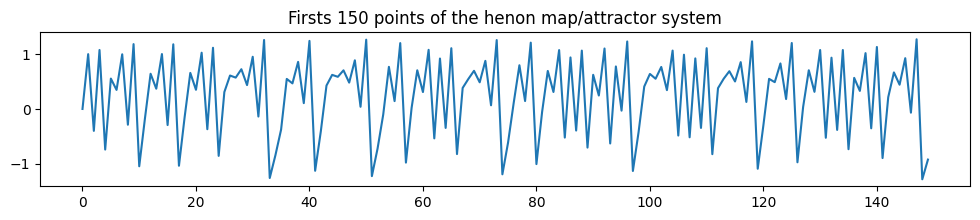

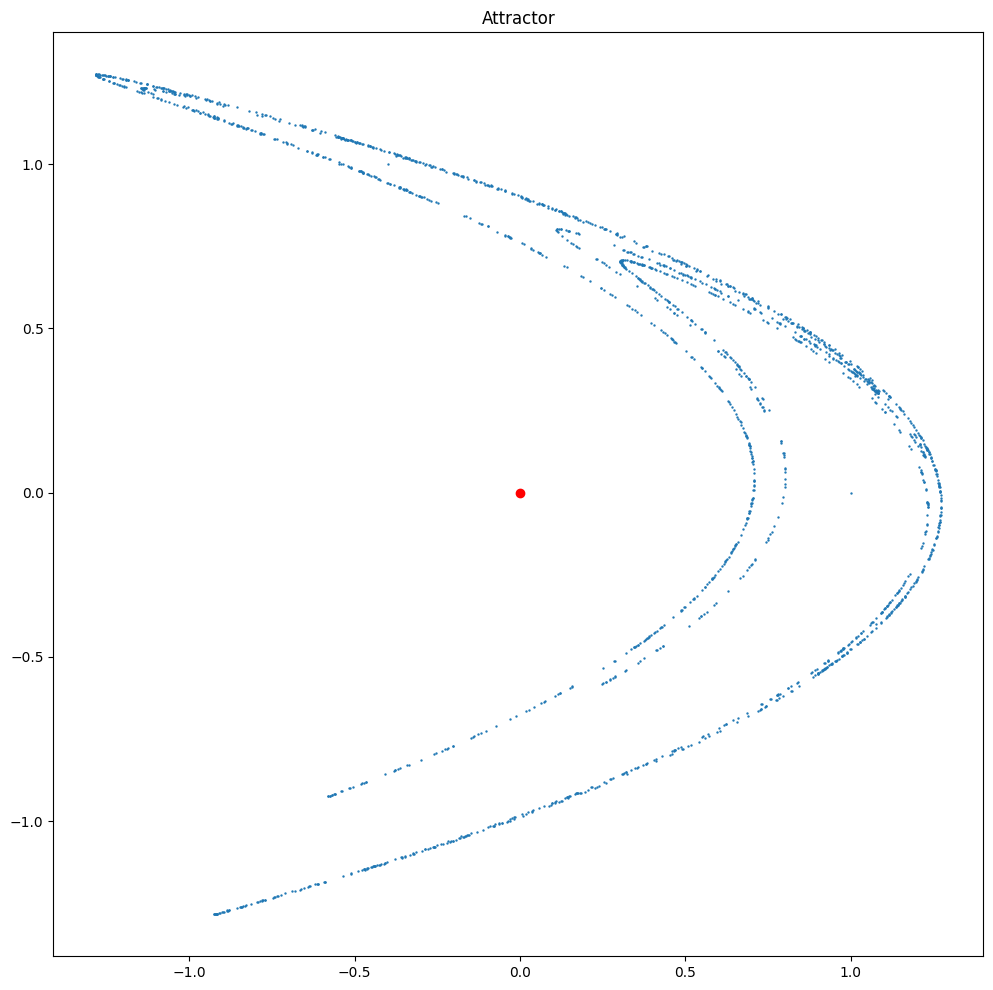

In [ ]:
# classic henon attractor
_ = henon_map(a=1.4, b=.3, n=2000, x0=0, y0=0)

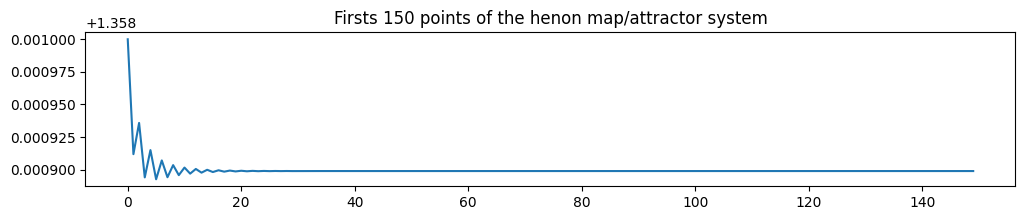

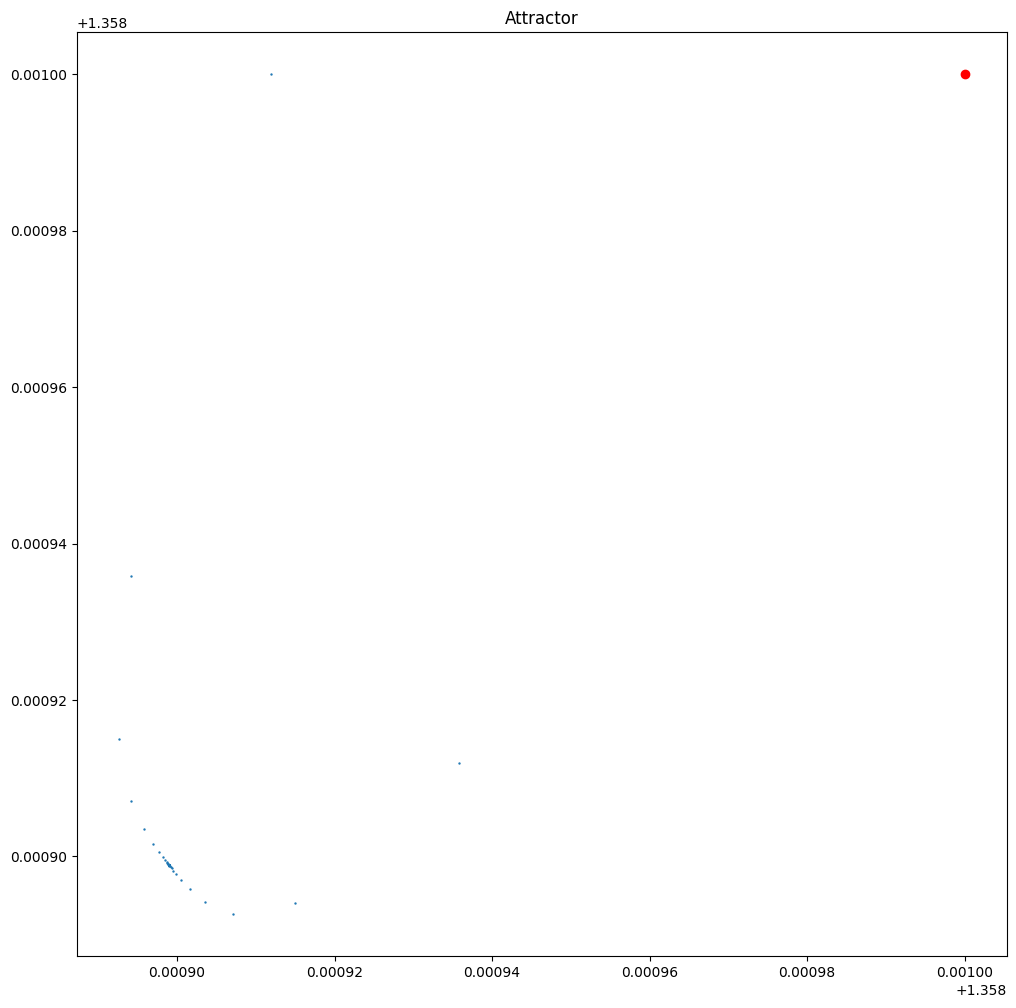

In [ ]:
# Converging henon map
_ = henon_map(a=.1, b=.4, n=150, x0=1.359, y0=1.359)

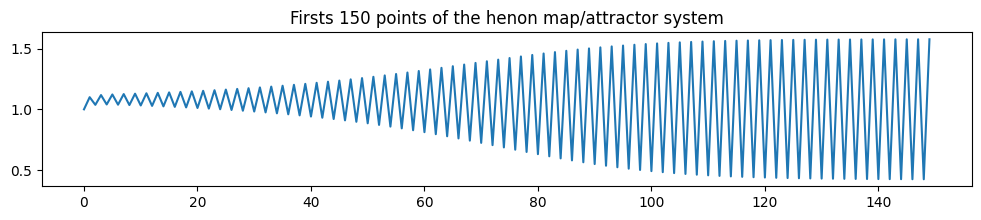

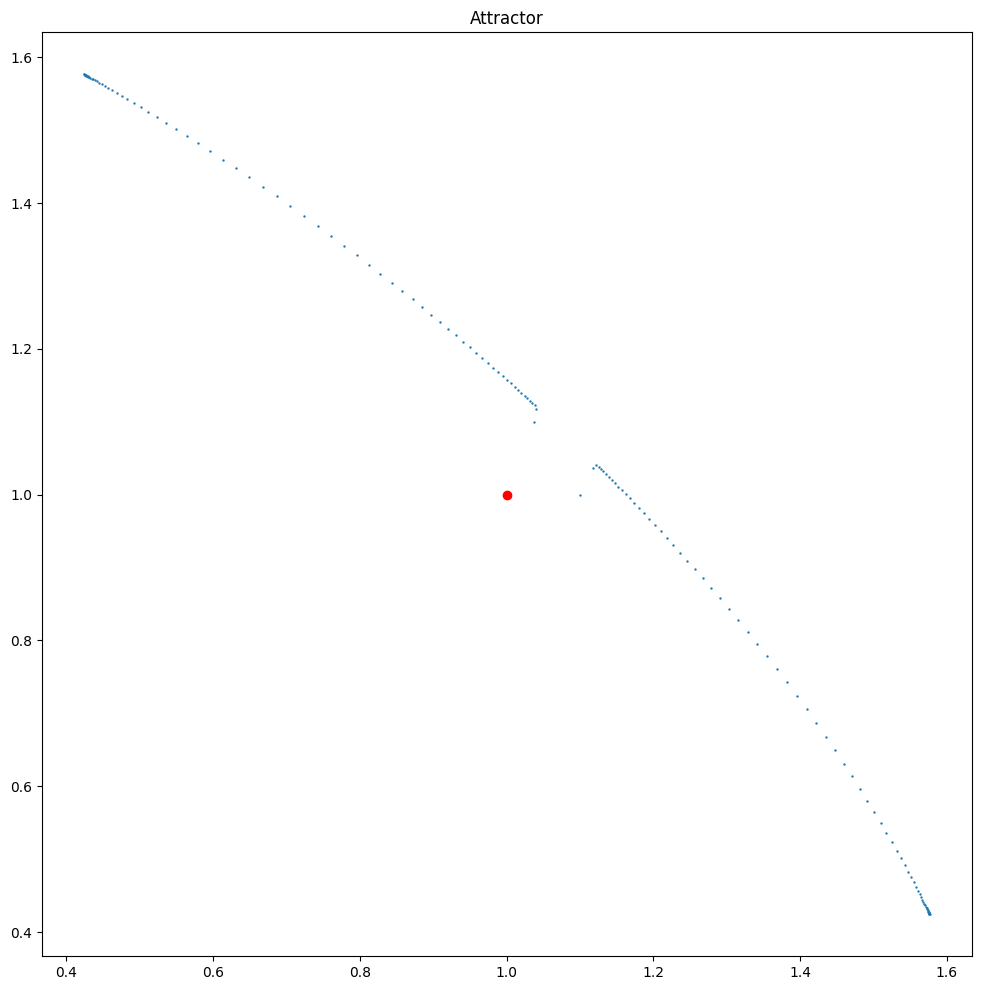

In [ ]:
# Non converging henon map
_ = henon_map(a=.3, b=.4, n=150, x0=1, y0=1)

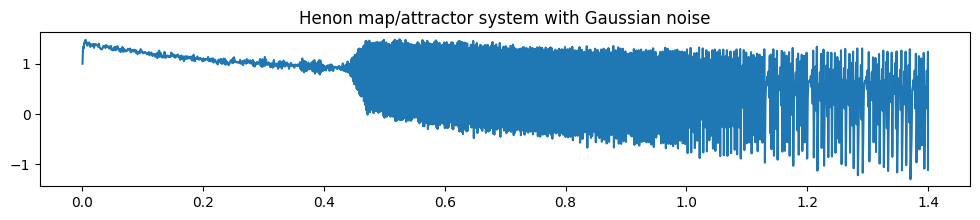

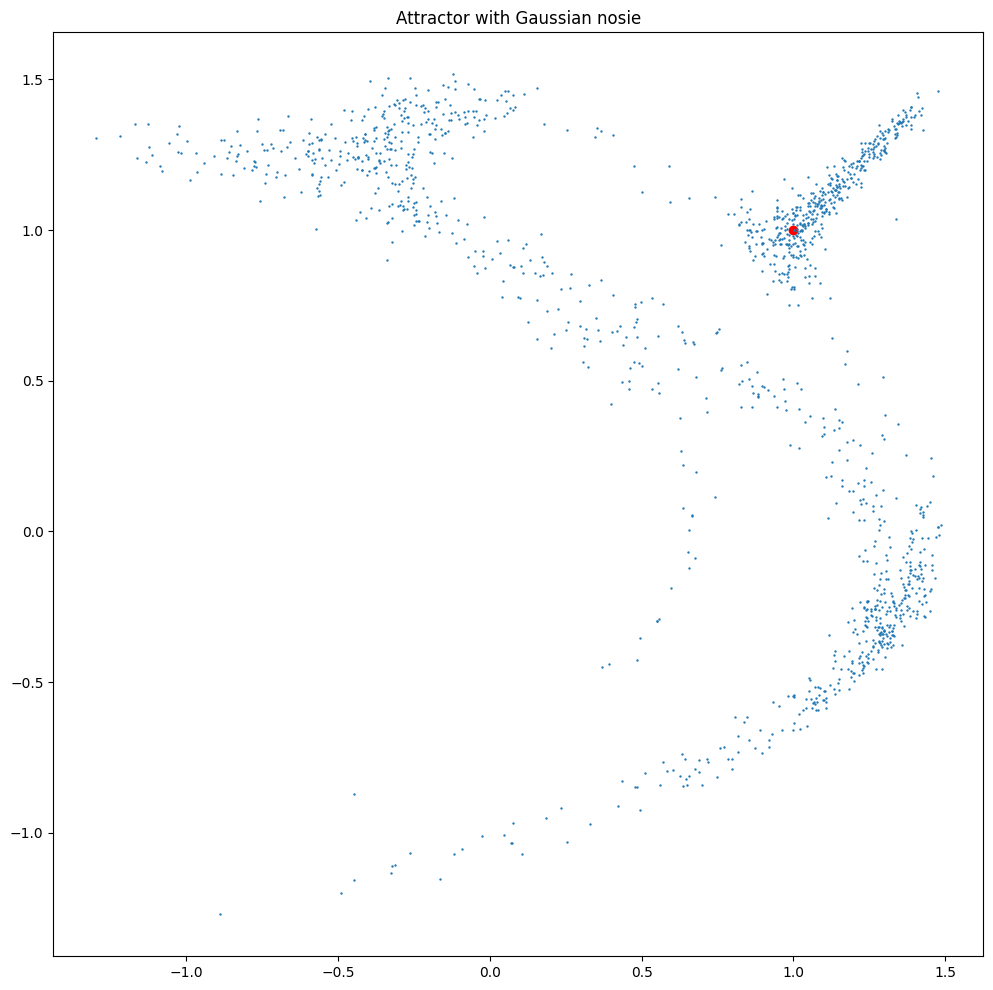

In [ ]:
# Reproduces in the first plot the graph available in Figure 2
# May need to be run more than once because of an overflow risk
_ = noisy_henon_map(b=0.3, timestep=0.001, noise_intensity=1, x0=1, y0=1, print_graph=True)

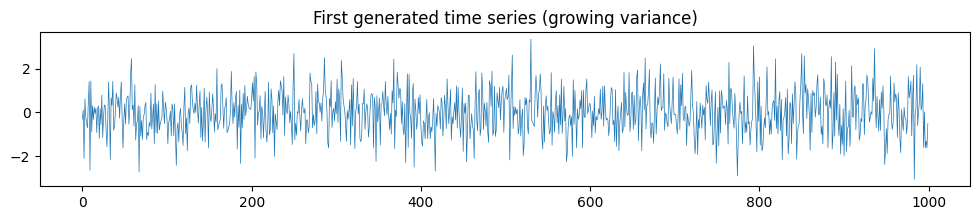

In [ ]:
white_noise = white_noise_with_growing_var(10)[1][0, :]
plt.figure(figsize=(12, 2))
plt.plot(white_noise, linewidth=0.5)
plt.title("First generated time series (growing variance)")
plt.show()

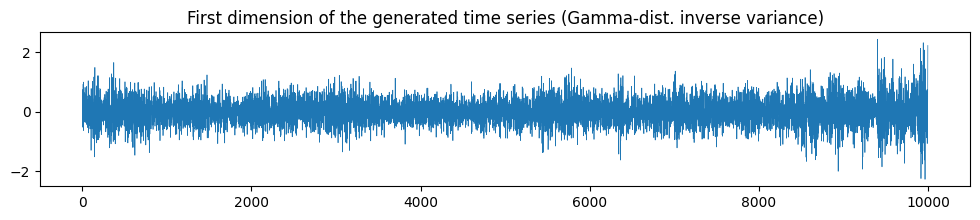

In [ ]:
white_noise = white_noise_with_gamma_inverse_var()[0, :]
plt.figure(figsize=(12, 2))
plt.plot(white_noise, linewidth=0.5)
plt.title("First dimension of the generated time series (Gamma-dist. inverse variance)")
plt.show()

> a) Hénon maps

In [ ]:
# Declares parameter b range for the Hénon Map generation
b_range = [0.27, 0.28, 0.29, 0.3]

# Simulates a 4D matrix composed of four generated
# noisy Hénon Maps
simulation = [noisy_henon_map(b=b,
                              timestep=0.001,
                              noise_intensity=1,
                              x0=1, y0=1,
                              print_graph=False)
              for b in b_range]

# Formats the simulations as a Pandas DataFrame
data = pd.DataFrame(np.array(simulation).T,
                    columns = [f"b_{b}" for b in b_range])
data.head()

b_0.27    b_0.28    b_0.29     b_0.3
0  1.000000  1.000000  1.000000  1.000000
1  1.242329  1.262772  1.292863  1.265103
2  1.211149  1.249346  1.247462  1.311377
3  1.292117  1.339302  1.389892  1.408832
4  1.310124  1.375057  1.374136  1.393176

In [ ]:
# Parameter declaration
w_window_size        = 50
k_homology_dimension = 1
m_landscape          = 5
n_nodes              = 200

# Computes landscapes
# /!\ memory intensive -- will require about several Gb of ram
# as it returns complete diagrams rather than only 1-loops if not
# computed with memory_saving
diagrams   = compute_persistence_diagrams(data,
                                          w_window_size,
                                          memory_saving=(True, k_homology_dimension))
landscapes = compute_persistence_landscapes(diagrams,
                                            k_homology_dimension,
                                            m_landscape,
                                            n_nodes,
                                            memory_saving=True)

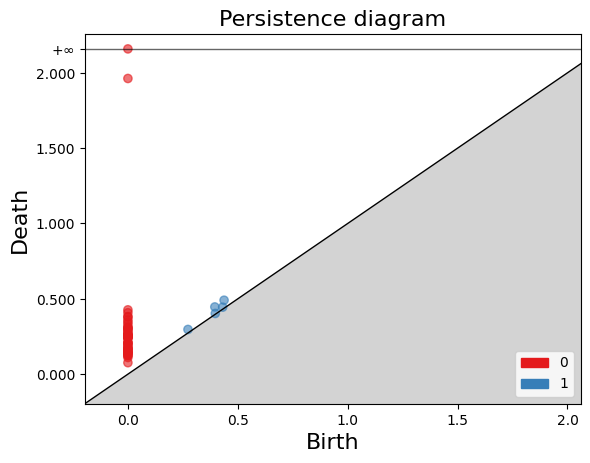

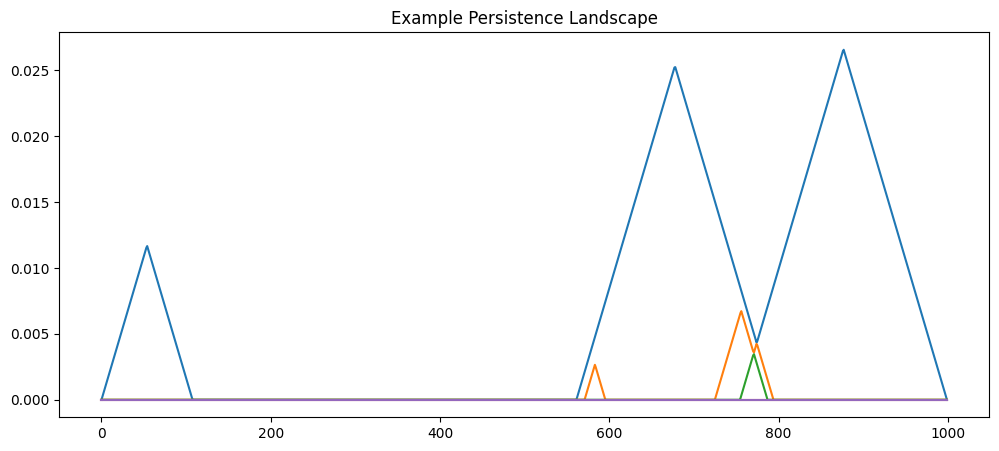

In [ ]:
example_diagram   = compute_persistence_diagram(data[1000:1000+w_window_size].values,
                                                True, True, (True, 1))
example_landscape = compute_persistence_landscape(example_diagram,
                                                  [np.min(example_diagram), np.max(example_diagram)],
                                                  1, 5, 1000, True)
plt.figure(figsize=(12, 5)); plt.plot(example_landscape.T)
plt.title("Example Persistence Landscape"); plt.show()

*Computation of the $L^1$ and $L^2$ norms*

In [ ]:
norms_df = compute_persistence_landscape_norms(landscapes)
df = pd.DataFrame(norms_df, columns=["L1", "L2"])

*$L^1$ and $L^2$ norms visualization*

<Axes: >

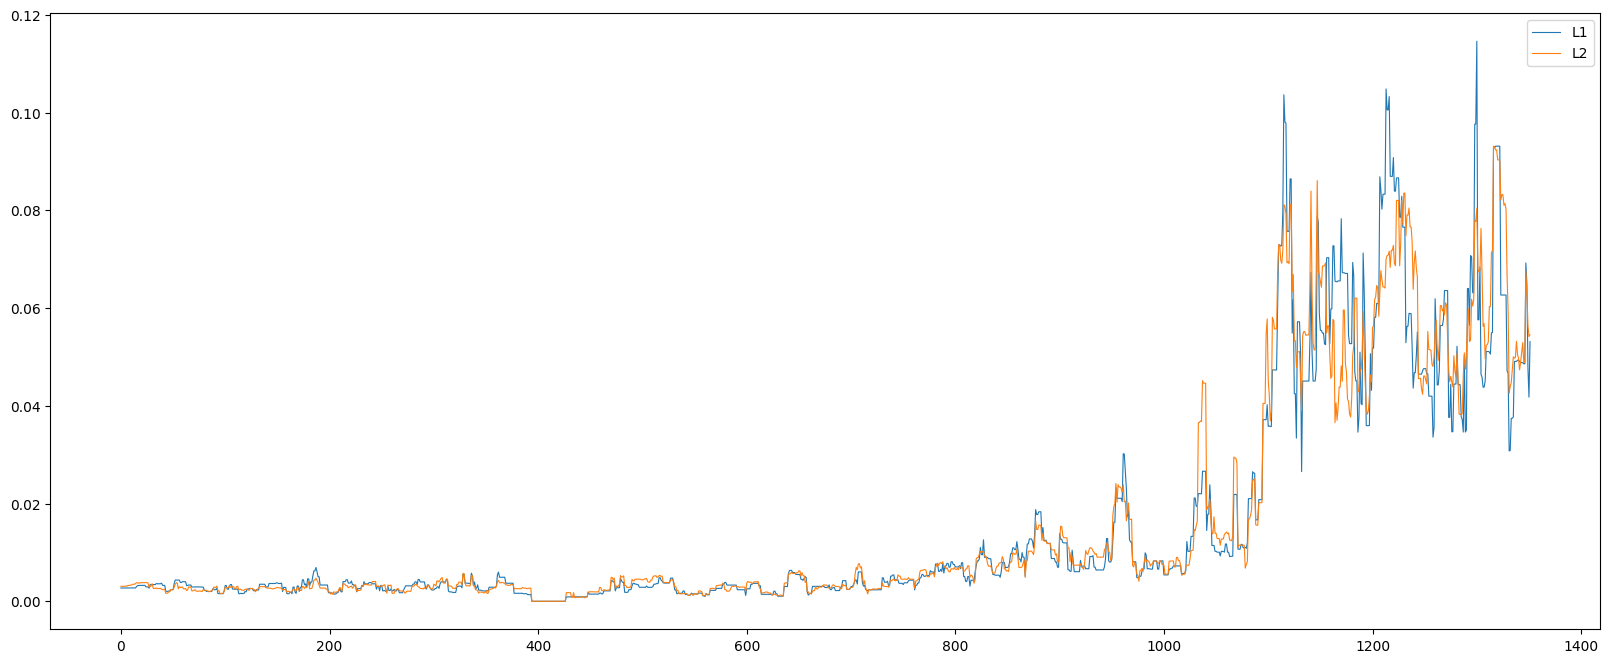

In [ ]:
df.plot(figsize=(20, 8), lw=0.8)

> b) White noise with growing variance

In [ ]:
# Simulates 10 4D matrices (with increasing variance) and
# Formats each as a Pandas DataFrame
simulations = white_noise_with_growing_var(10)
data = {k: pd.DataFrame(simulations[k].T) for k in simulations.keys()}

# Print an example header
data[1].head()

0         1         2         3
0 -0.265001  0.447400 -0.510652 -1.254454
1 -0.735547  0.687466  1.795806 -1.025539
2 -0.839385  0.011838  0.562294  0.053871
3 -0.069946 -0.485222  1.130912  1.301913
4 -0.366093 -0.156988 -0.064996 -0.781654

In [ ]:
# Parameter declaration
w_window_size        = 50
k_homology_dimension = 1
m_landscape          = 5
n_nodes              = 100

# Computes landscapes
# /!\ memory intensive -- will require about several Gb of ram
# as it returns complete diagrams rather than only 1-loops
c_diagrams   = lambda d, w: compute_persistence_diagrams(
    d, w, memory_saving=(True, k_homology_dimension)
)
c_landscapes = lambda d, k, m, n: compute_persistence_landscapes(
    d,k,m,n, memory_saving=True
)
landscapes   = {k: c_landscapes(c_diagrams(data[k], w_window_size),
                                k_homology_dimension, m_landscape, n_nodes)
                for k in data.keys()}

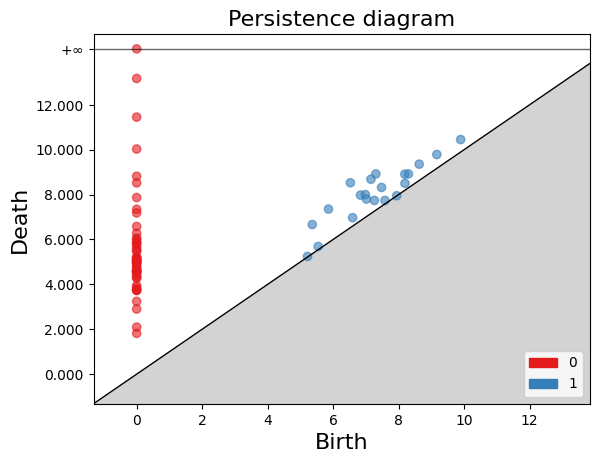

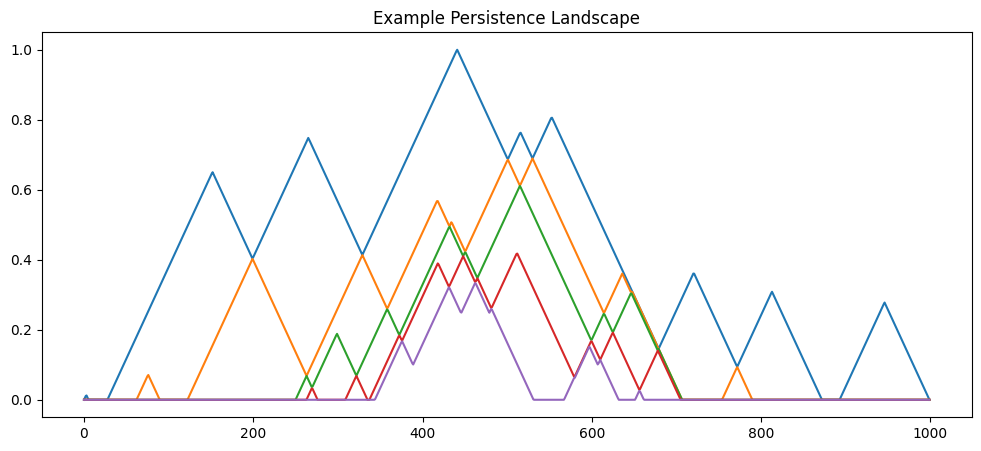

In [ ]:
example_diagram   = compute_persistence_diagram(data[5][100:100+w_window_size].values,
                                                True, True, (True, 1))
example_landscape = compute_persistence_landscape(example_diagram,
                                                  [np.min(example_diagram), np.max(example_diagram)],
                                                  1, 5, 1000, True)
plt.figure(figsize=(12, 5)); plt.plot(example_landscape.T)
plt.title("Example Persistence Landscape"); plt.show()

*Computation of the $L^1$ and $L^2$ norms*

In [ ]:
# Computes the L1 and L2 norms of the 10 white-noises with gamma-distributed variance
# processes
c_norms = lambda l: compute_persistence_landscape_norms(l)
norms_dfs = {k: pd.DataFrame(c_norms(landscapes[k]), columns=["L1", "L2"])
             for k in landscapes.keys()}

# Extracts the L1 norms in a single Pandas DataFrame
L1_norms = np.array([norms_dfs[k]["L1"] for k in norms_dfs.keys()]).T
L1_norms = pd.DataFrame(L1_norms, columns=[f"var_{v+1}" for v in range(10)])

# Extracts the L2 norms in a single Pandas DataFram
L2_norms = np.array([norms_dfs[k]["L2"] for k in norms_dfs.keys()]).T
L2_norms = pd.DataFrame(L2_norms, columns=[f"var_{v+1}" for v in range(10)])

*$L^1$ and $L^2$ norms visualization*

<Axes: >

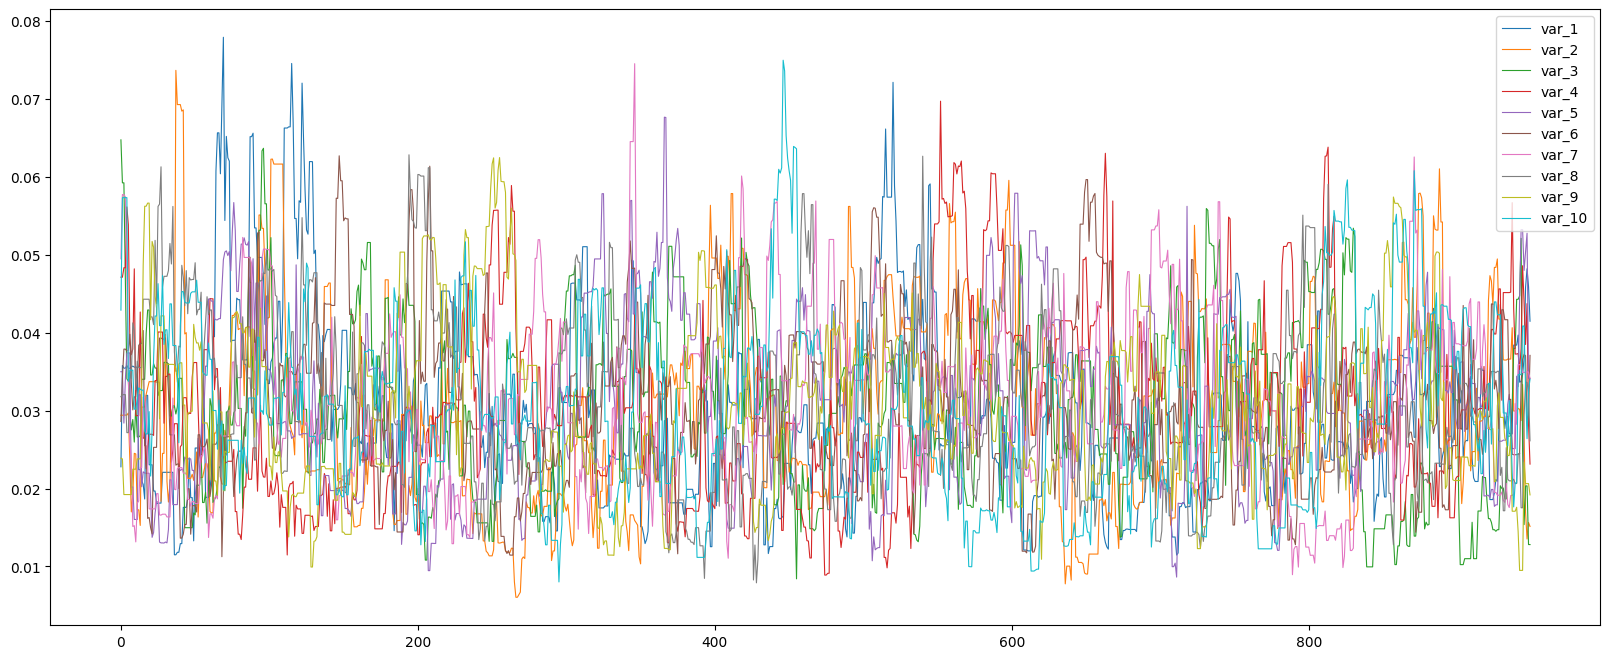

In [ ]:
L1_norms.plot(figsize=(20, 8), lw=0.8)

<Axes: >

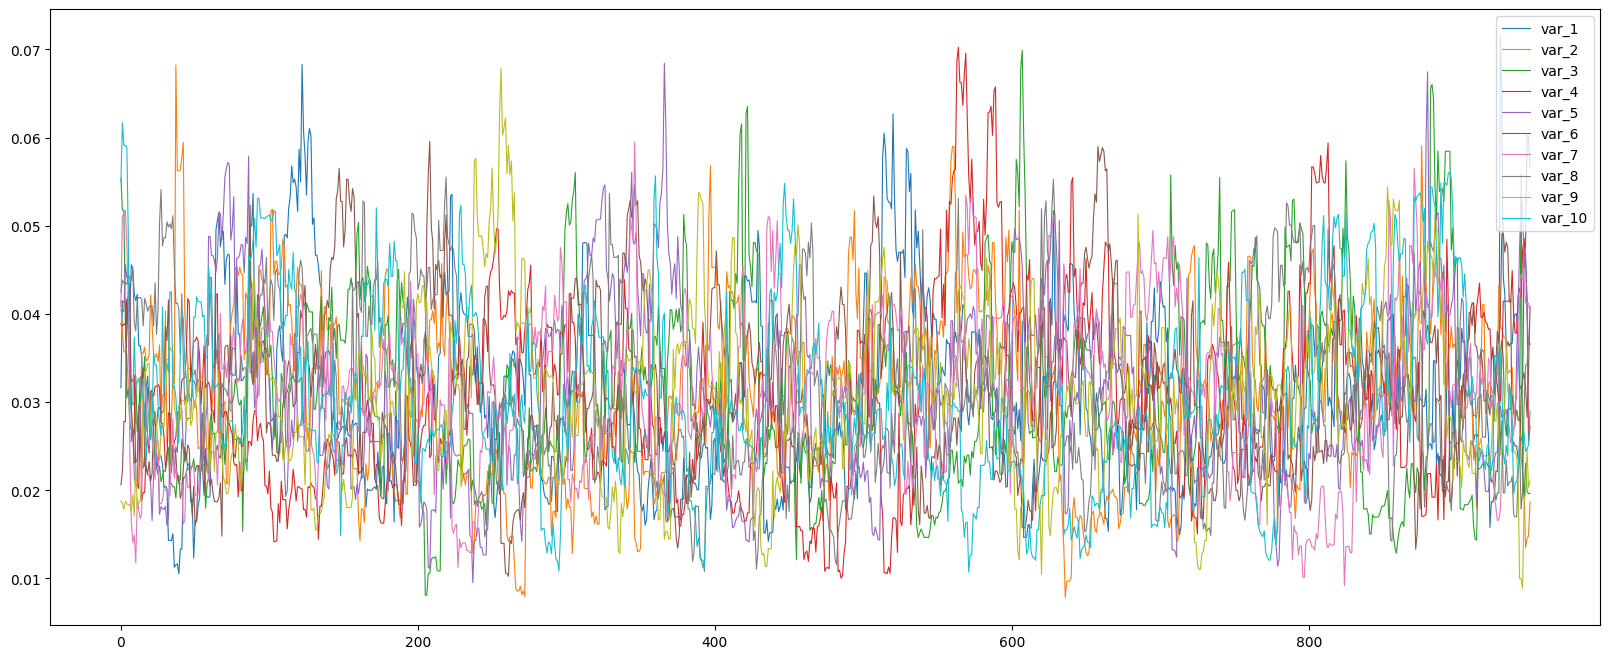

In [ ]:
L2_norms.plot(figsize=(20, 8), lw=0.8)

> c) White noise with Gamma-distributed inverse variance

In [ ]:
# Simulates a 4D matrix made with a gamma distributed variance
data = pd.DataFrame(white_noise_with_gamma_inverse_var().T)

# Print an example header
data.head()

0         1         2         3
0  0.449427  0.397513 -0.367690  0.147860
1 -0.093584  0.317160 -0.400809 -0.603639
2 -0.690975  0.397349  0.651577 -0.130829
3  0.250710 -0.095589  0.007728  0.105669
4  0.370378 -0.168492 -0.125839 -0.215229

In [ ]:
# Parameter declaration
w_window_size        = 50
k_homology_dimension = 1
m_landscape          = 5
n_nodes              = 1000

# Computes landscapes
# /!\ memory intensive -- will require about several Gb of ram
# as it returns complete diagrams rather than only 1-loops
diagrams   = compute_persistence_diagrams(data,
                                          w_window_size,
                                          memory_saving = (True, k_homology_dimension))
landscapes = compute_persistence_landscapes(diagrams,
                                            k_homology_dimension,
                                            m_landscape,
                                            n_nodes,
                                            memory_saving=True)

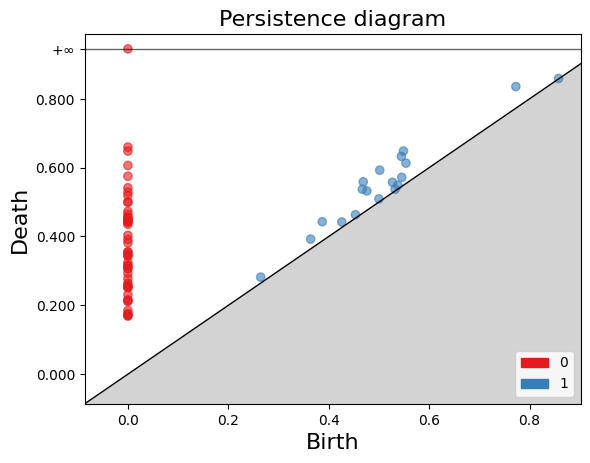

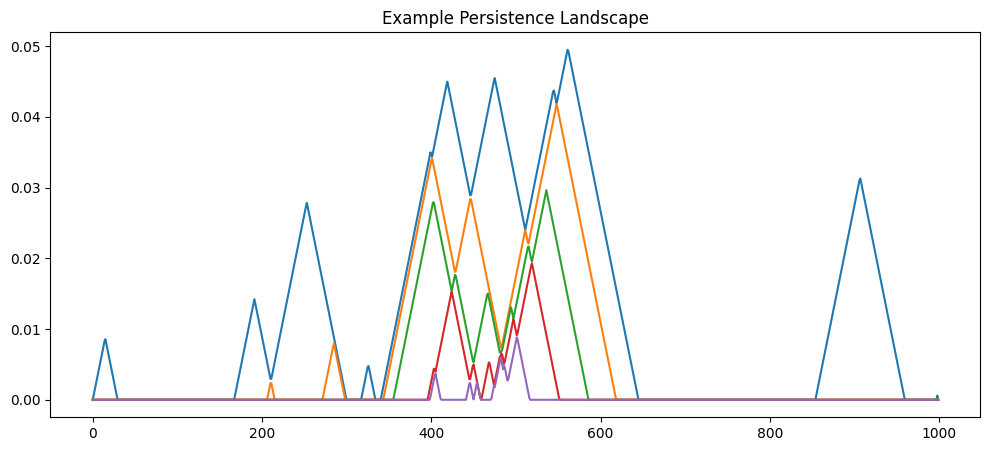

In [ ]:
example_diagram   = compute_persistence_diagram(data[100:100+w_window_size].values,
                                                True, True, (True, 1))
example_landscape = compute_persistence_landscape(example_diagram,
                                                  [np.min(example_diagram), np.max(example_diagram)],
                                                  1, 5, 1000, True)
plt.figure(figsize=(12, 5)); plt.plot(example_landscape.T)
plt.title("Example Persistence Landscape"); plt.show()

*Computation of the $L^1$ and $L^2$ norms*

In [ ]:
norms_df = compute_persistence_landscape_norms(landscapes)
df = pd.DataFrame(norms_df, columns=["L1", "L2"])

*$L^1$ and $L^2$ norms visualization*

<Axes: >

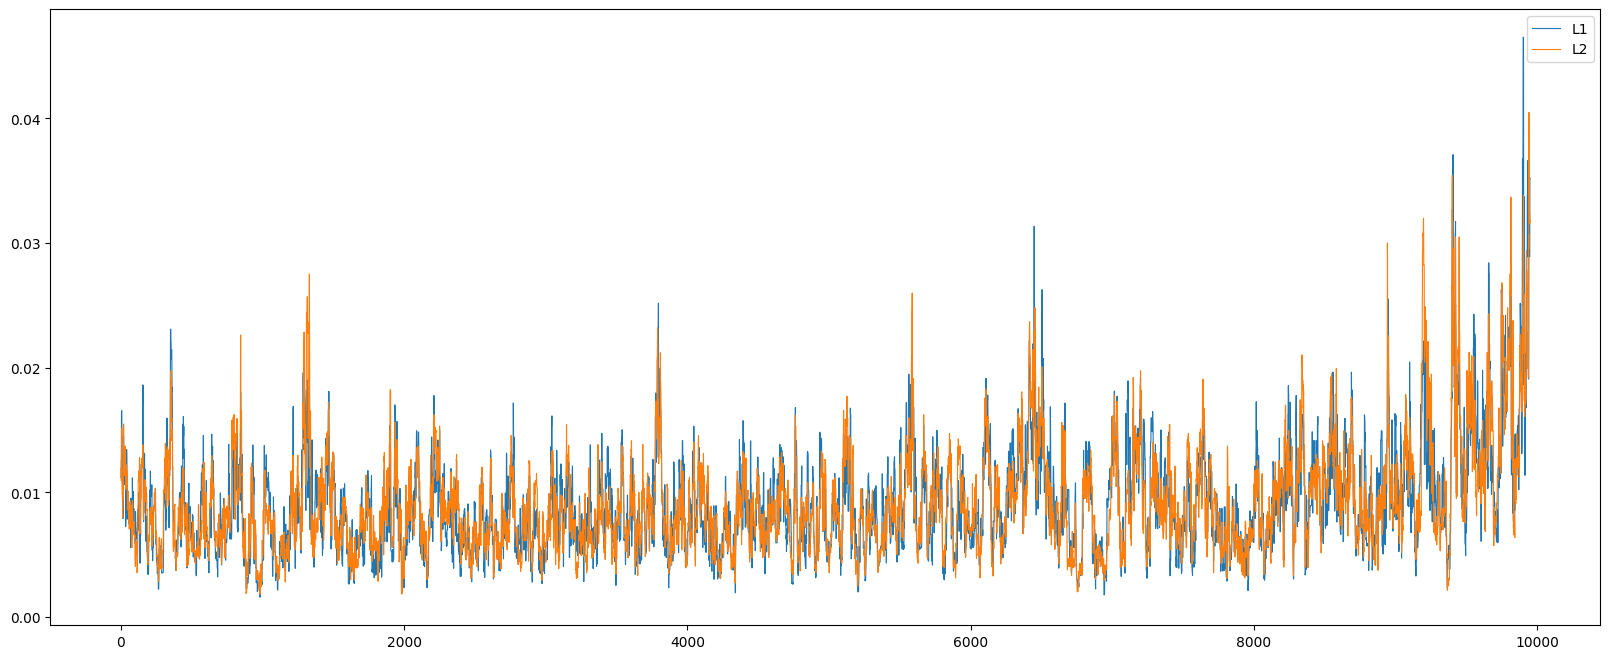

In [ ]:
df.plot(figsize=(20, 8), lw=0.8)

## II/Section 4 Experiments




<u>Retrieving the adjusted close log returns:</u>

For our reproduction, we reuse the same data as the paper: the log-returns of the adjusted close for each of the four US stock indexes.

In [ ]:

dowjones_lr = list(dowjones["Adj Close_lr"][1:])
nasdaq_lr = list(nasdaq["Adj Close_lr"][1:])
russel2000_lr = list(russel2000["Adj Close_lr"][1:])
sp500_lr = list(sp500["Adj Close_lr"][1:])
index = list(dowjones["Date"][1:])  # Adjust indexing to match other series if needed

# Check if all series are of the same length
min_length = min(len(dowjones_lr), len(nasdaq_lr), len(russel2000_lr), len(sp500_lr))

# Truncate lists to the minimum length
dowjones_lr = dowjones_lr[:min_length]
nasdaq_lr = nasdaq_lr[:min_length]
russel2000_lr = russel2000_lr[:min_length]
sp500_lr = sp500_lr[:min_length]
index = index[:min_length]

# Create the DataFrame
data = pd.DataFrame({
    "dowjones": dowjones_lr,
    "nasdaq": nasdaq_lr,
    "russel2000": russel2000_lr,
    "sp500": sp500_lr
}, index=index)

# Display the DataFrame
print(data)


            dowjones    nasdaq  russel2000     sp500
1987-12-24 -0.002981 -0.004975    0.006518 -0.004474
1987-12-28 -0.028764 -0.007425   -0.021531 -0.025966
1987-12-29 -0.008310 -0.033513   -0.005900 -0.003999
1987-12-30  0.011973 -0.030809    0.010093  0.013281
1987-12-31 -0.005796  0.014080    0.007669 -0.003152
...              ...       ...         ...       ...
2016-12-02 -0.001121  0.037101    0.000342  0.000397
2016-12-05  0.002387  0.007703    0.017753  0.005804
2016-12-06  0.001848 -0.001237    0.011061  0.003405
2016-12-07  0.015352 -0.004051    0.008715  0.013077
2016-12-08  0.003329  0.008960    0.015893  0.002157

[7300 rows x 4 columns]


<u>Computing the persistence diagrams and landscapes, and the corresponding $L^1$ and $L^2$ norms at window size $40$, $80$, and $120$:</u>

$$w=40$$

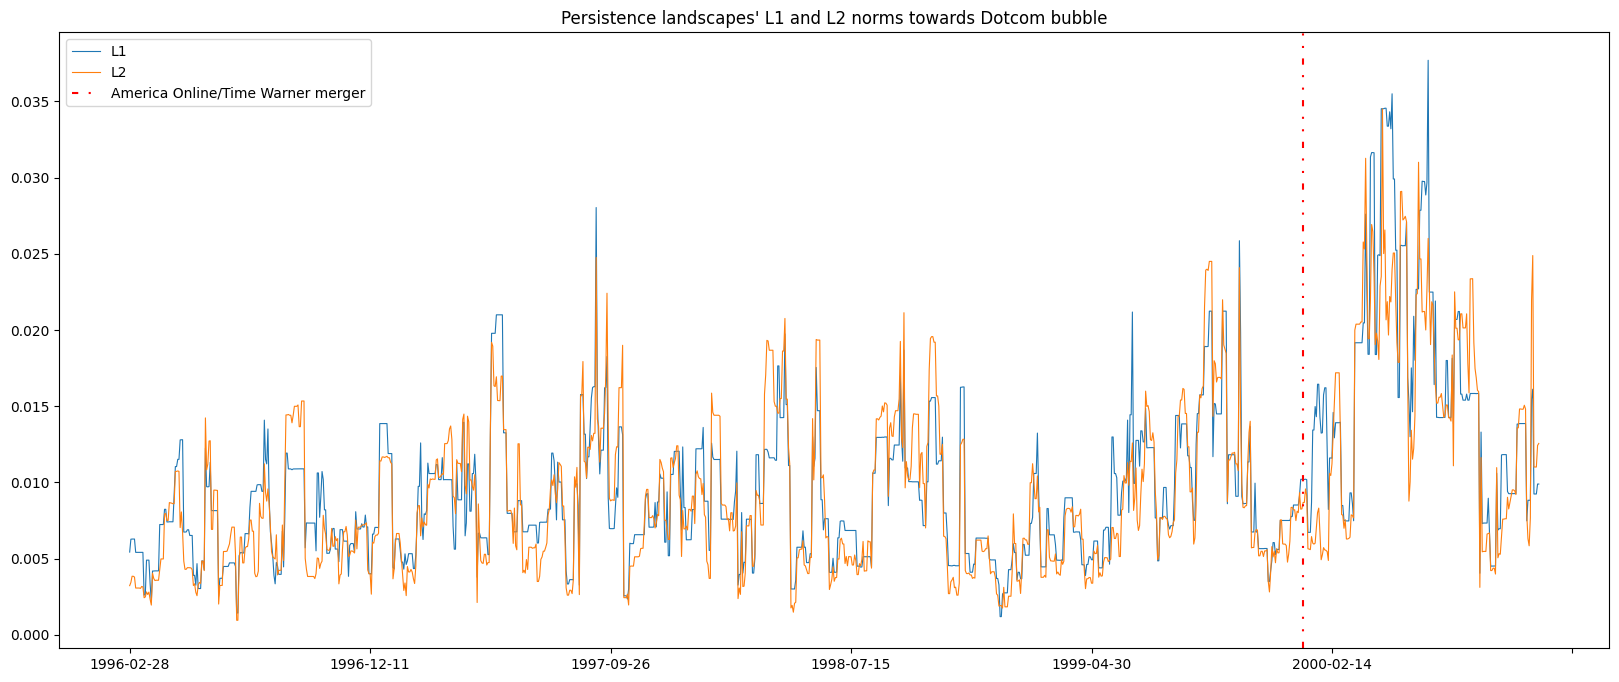

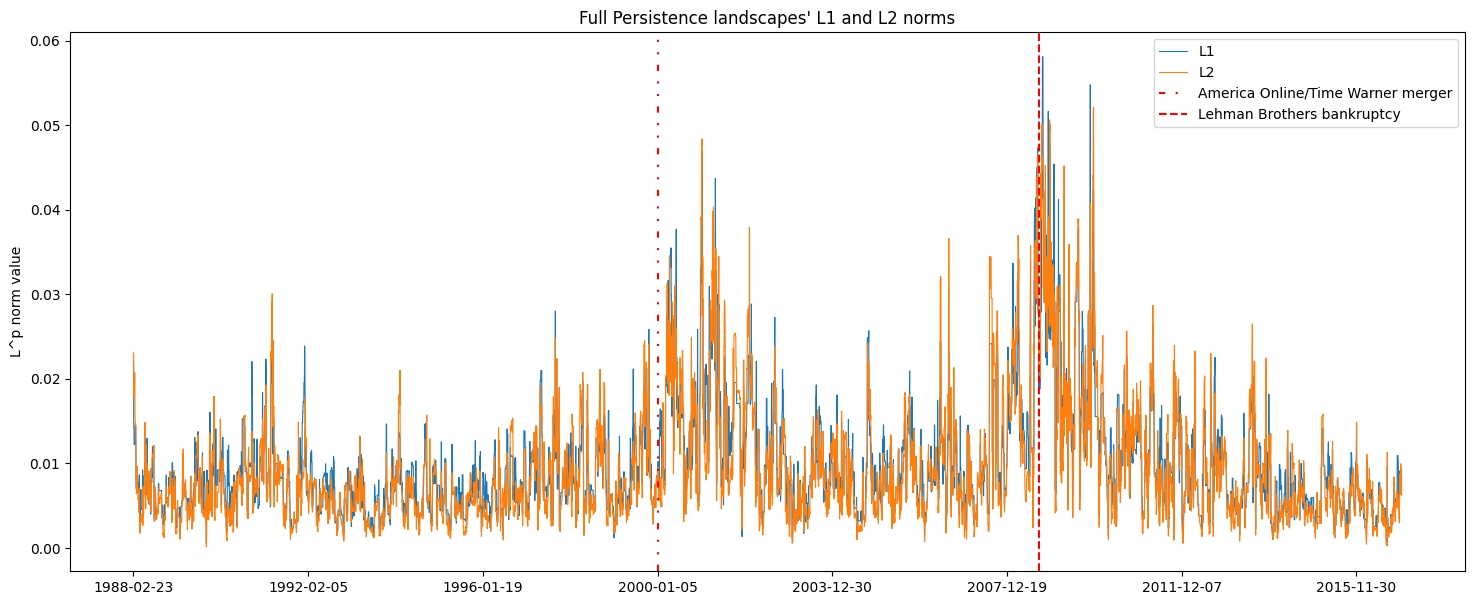

In [ ]:
d1, l1, norms = reproduce_paper_process(data, 40, 1, 5, 1000, (True, 1))


$$w=80$$

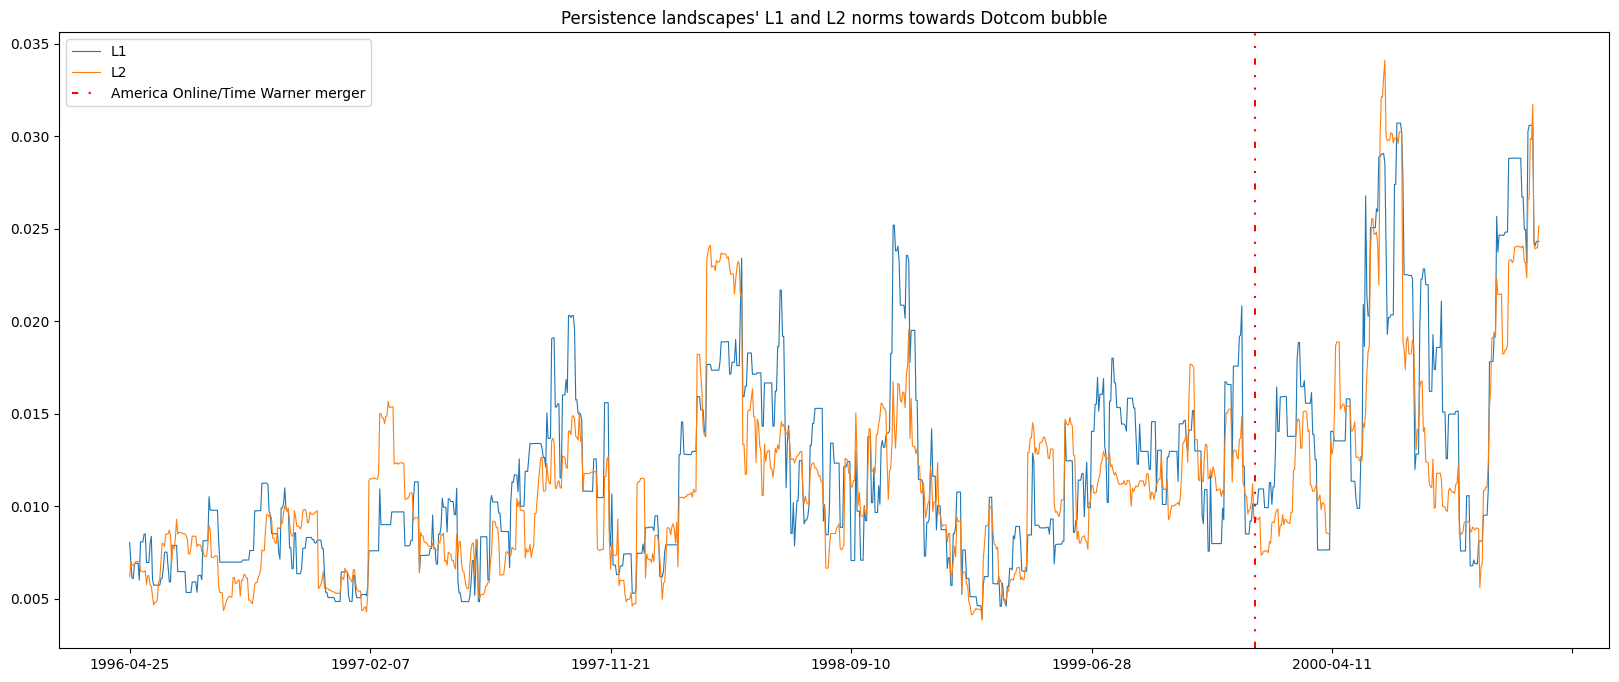

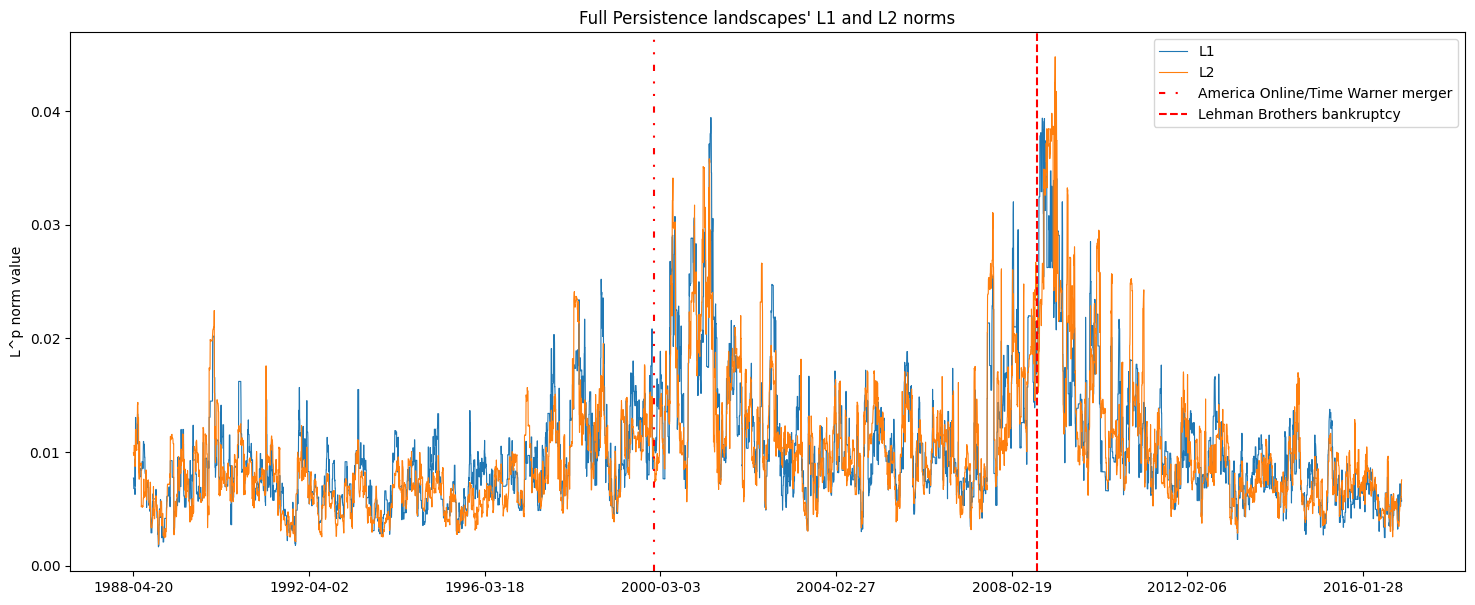

In [ ]:
d2, l2, norms = reproduce_paper_process(data, 80, 1, 5, 1000, (True, 1))


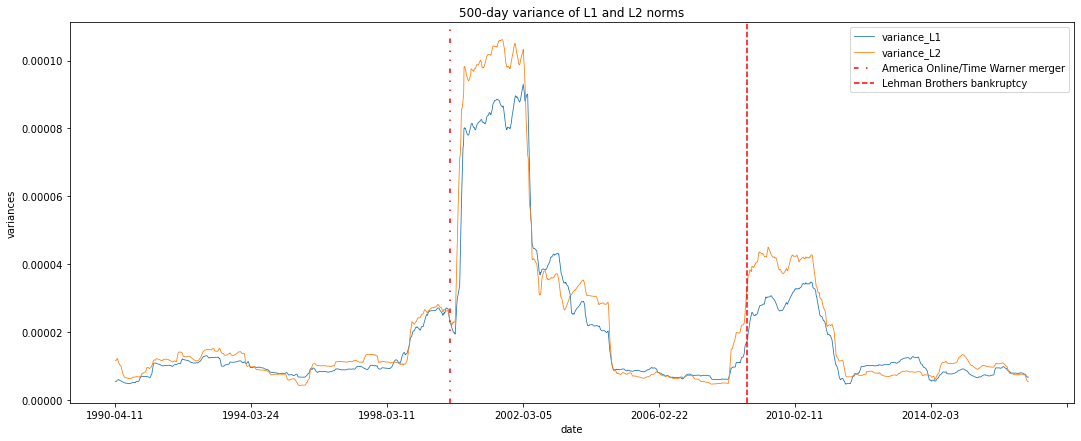

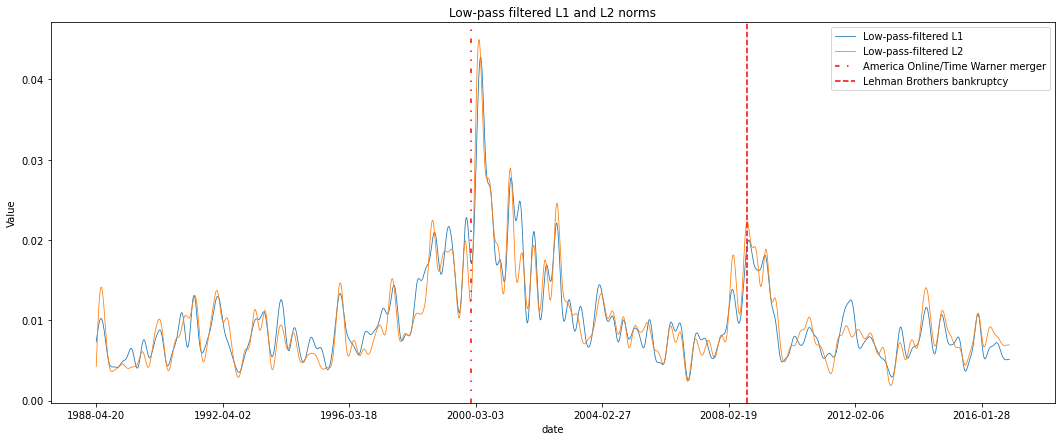

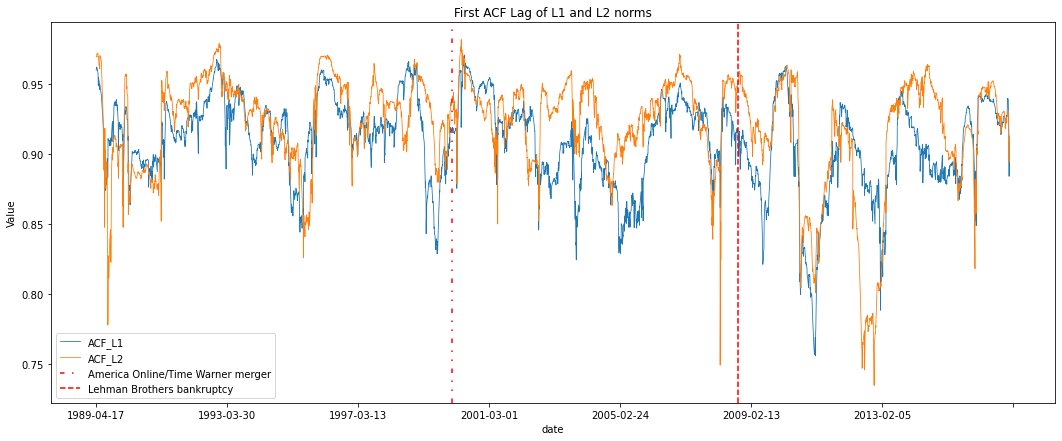

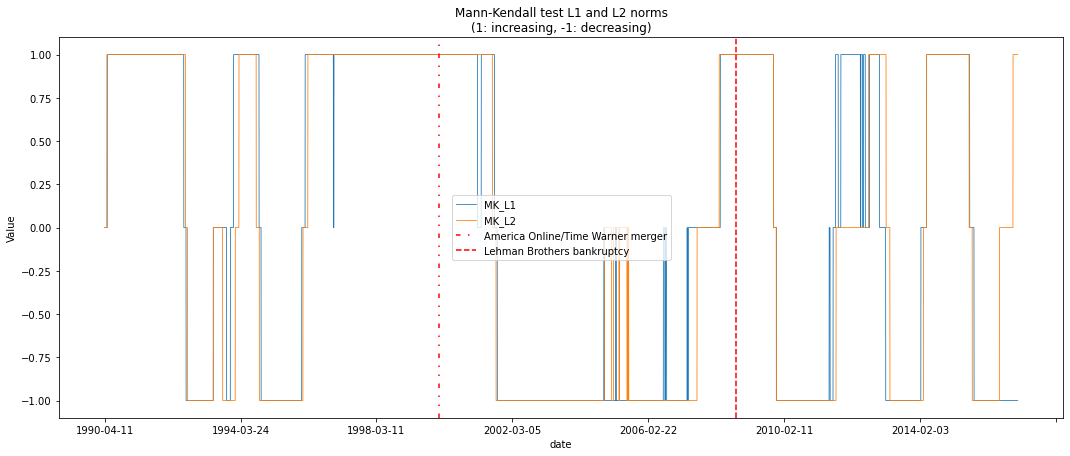

In [ ]:
statistical_test_suite_for_l1l2norms(data, norms, 80)

$$w=120$$

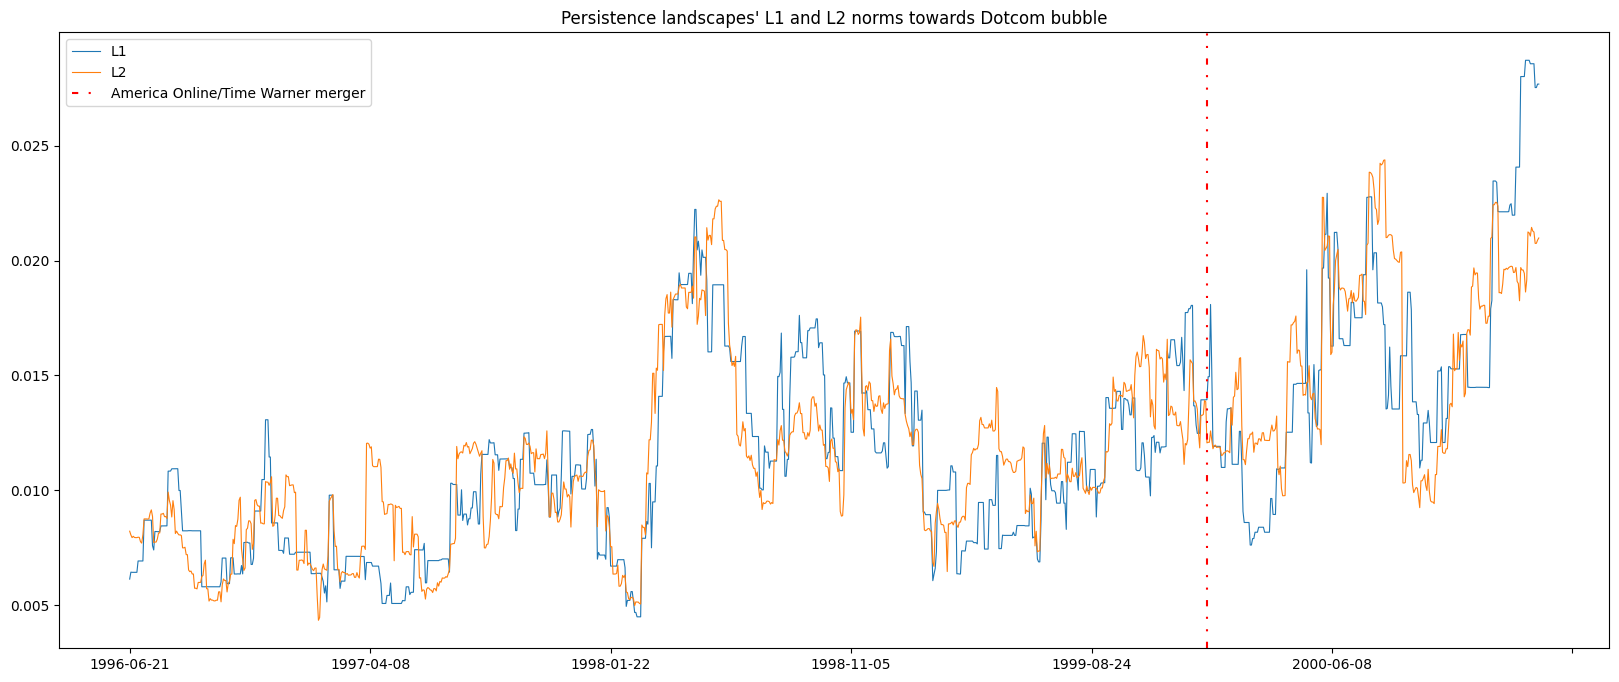

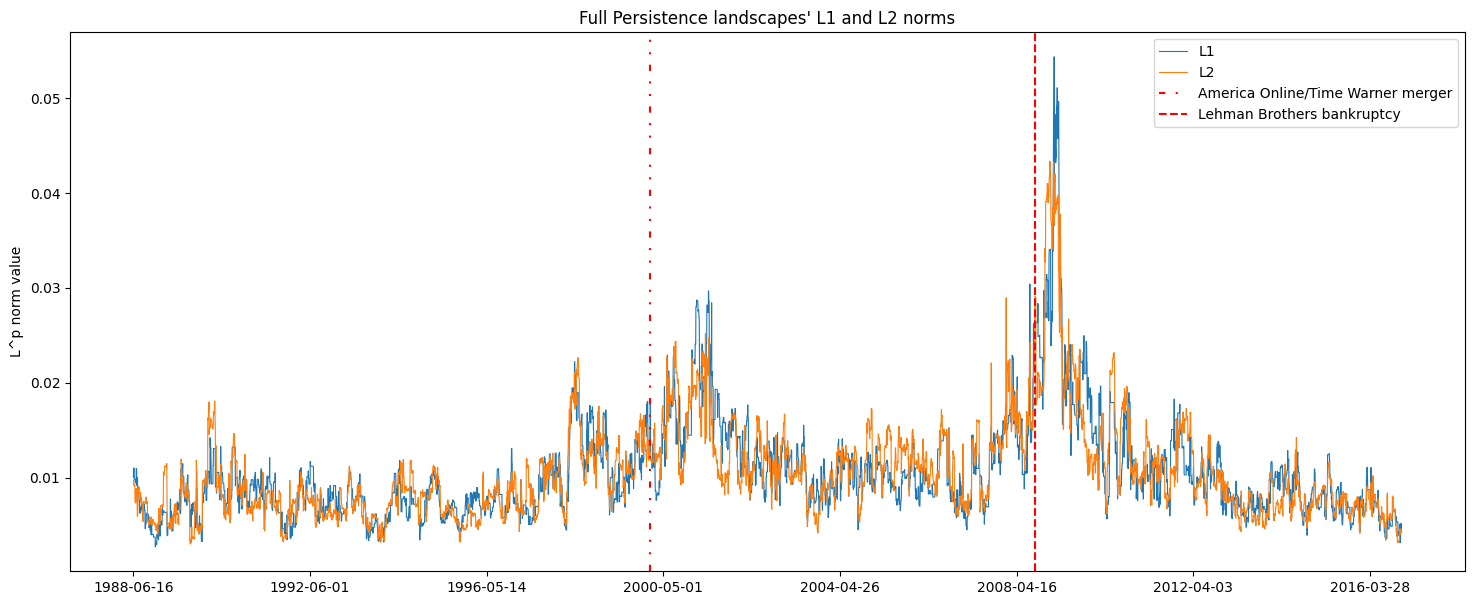

In [ ]:
d3, l3, norms = reproduce_paper_process(data, 120, 1, 5, 1000, (True, 1))


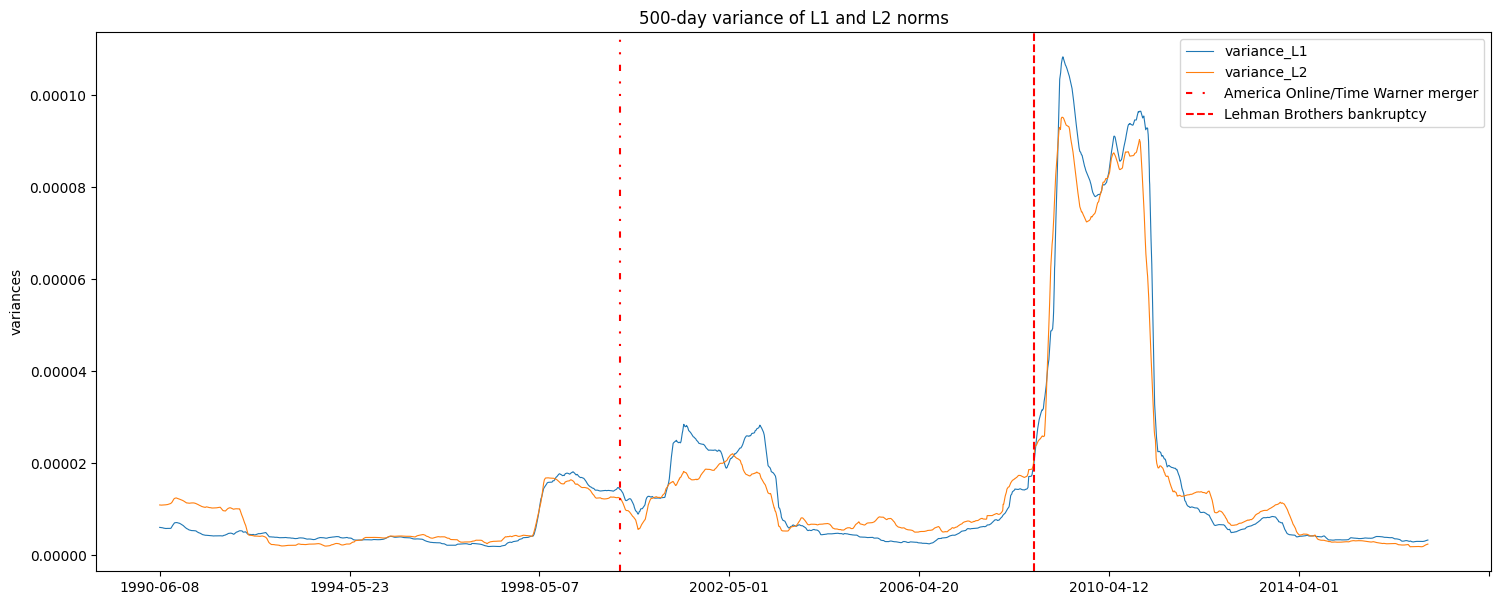

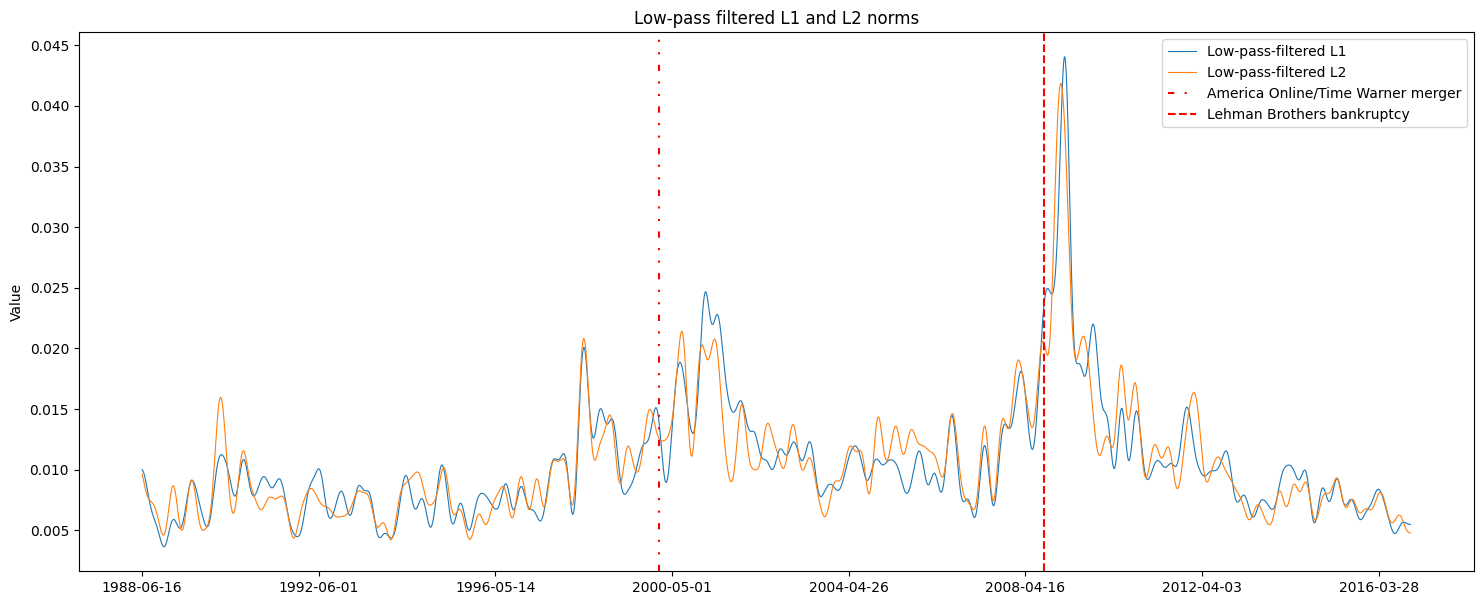

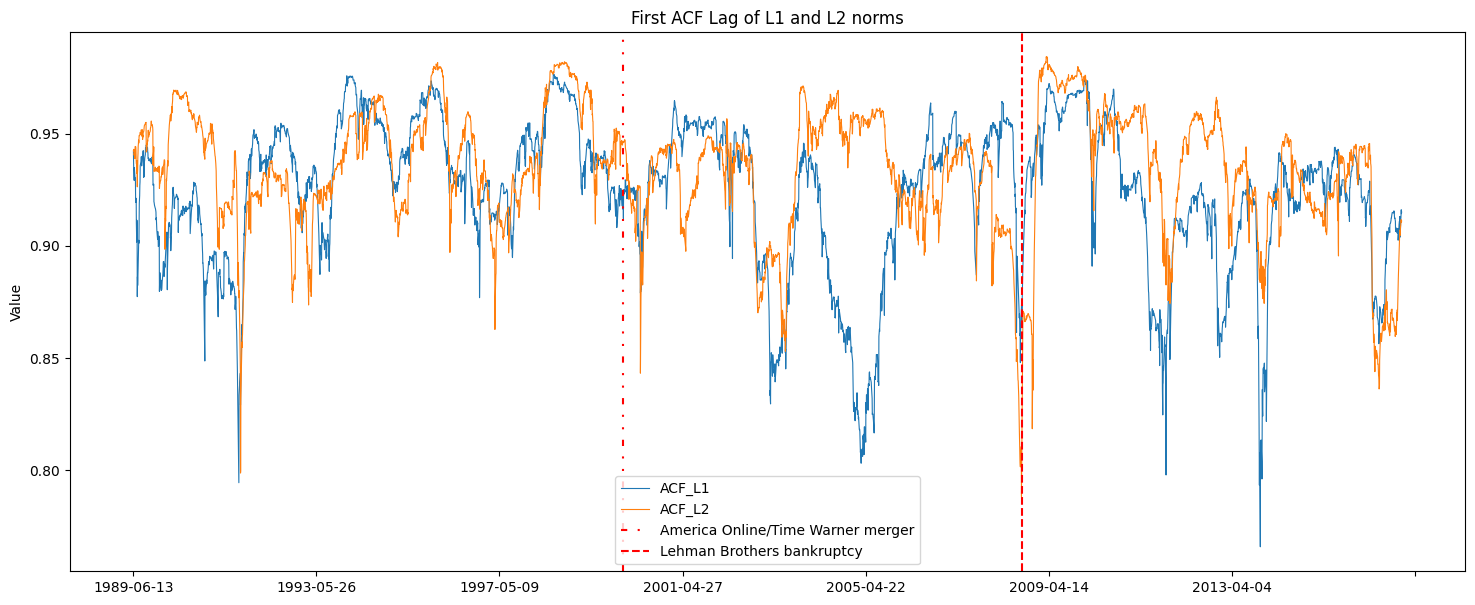

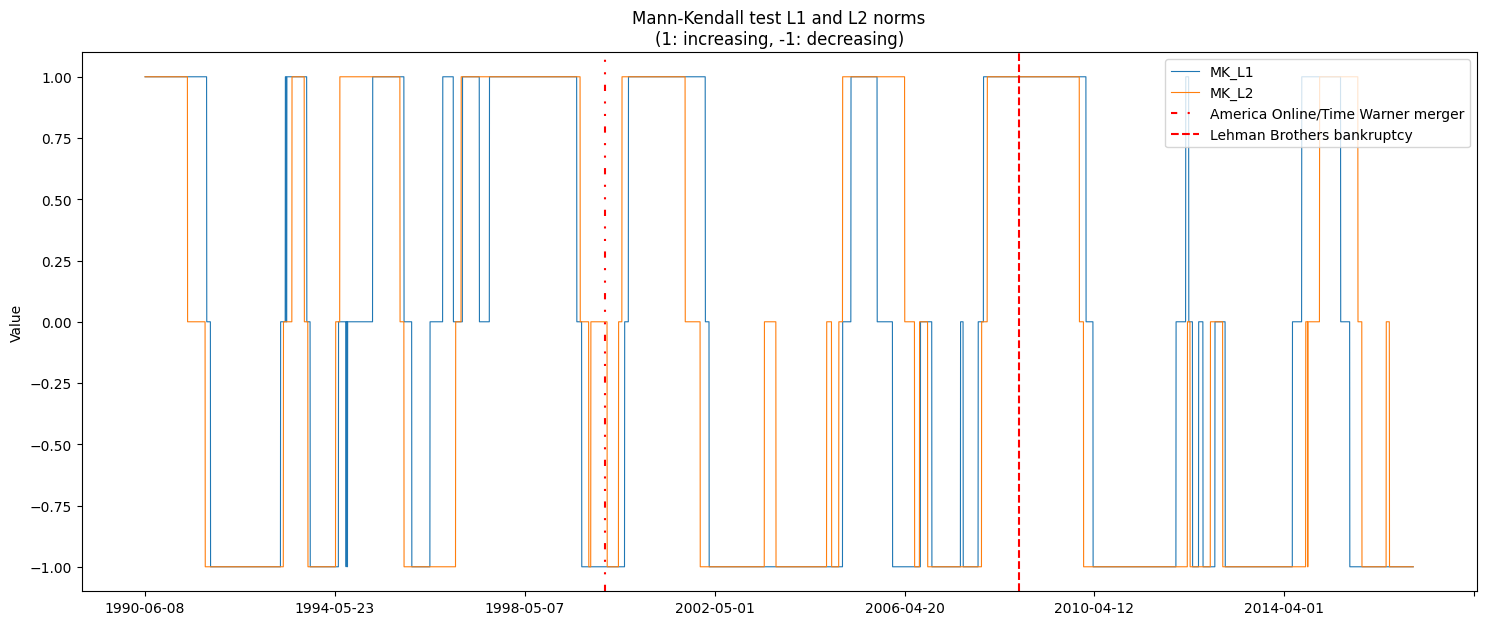

In [ ]:
statistical_test_suite_for_l1l2norms(data, norms, 120)

#III/ Exploring Further Avenues

<u>Norm of the difference between landscapes:</u>


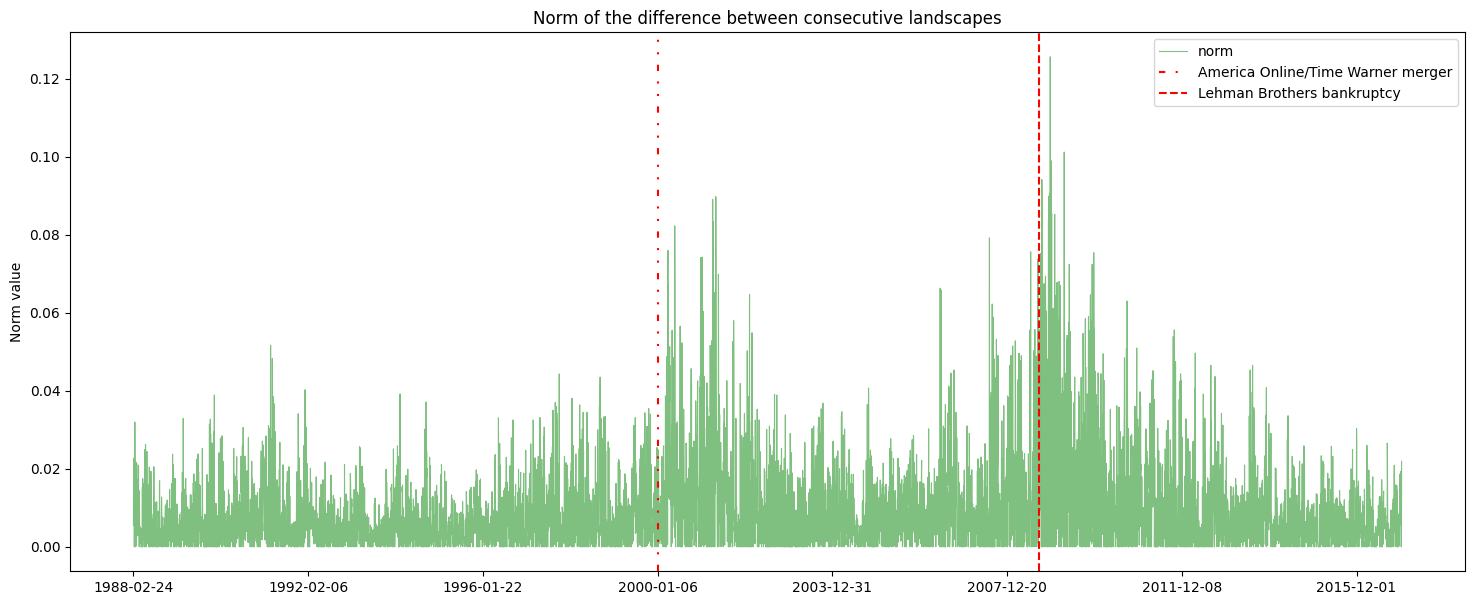

In [ ]:
norm_diff1 = compute_norm_difference_persistence_landscapes(data, l1)

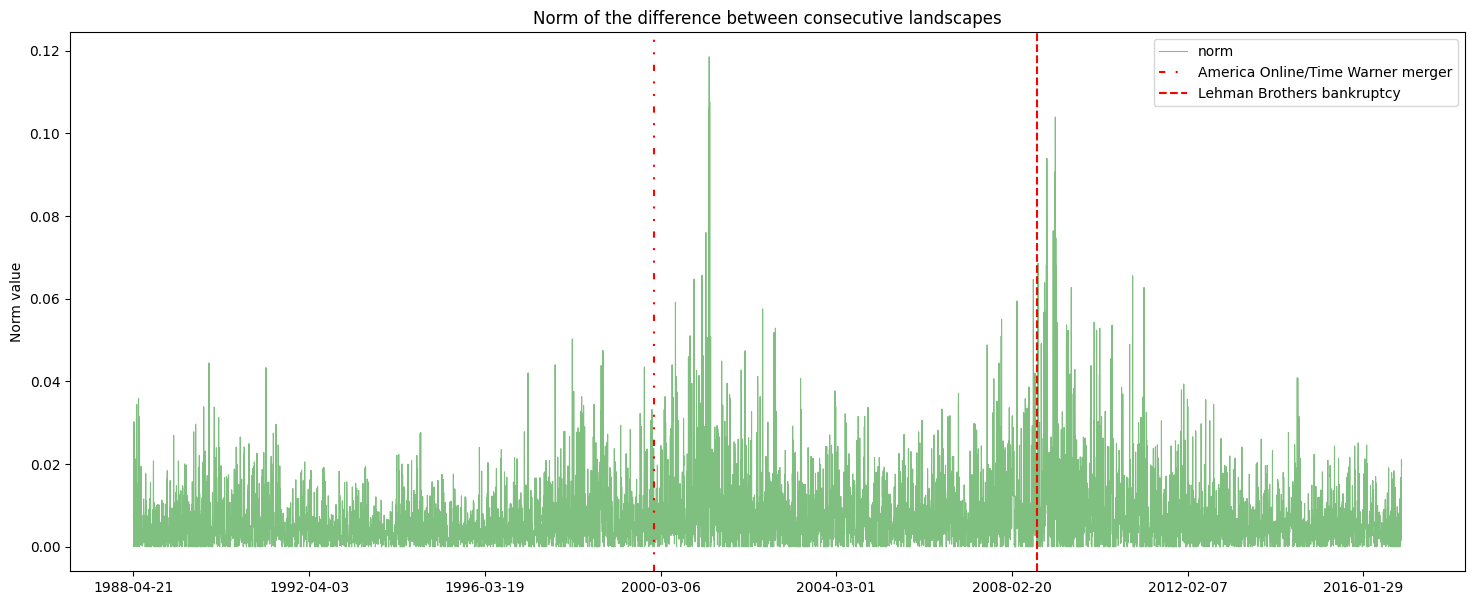

In [ ]:
norm_diff2 = compute_norm_difference_persistence_landscapes(data, l2)

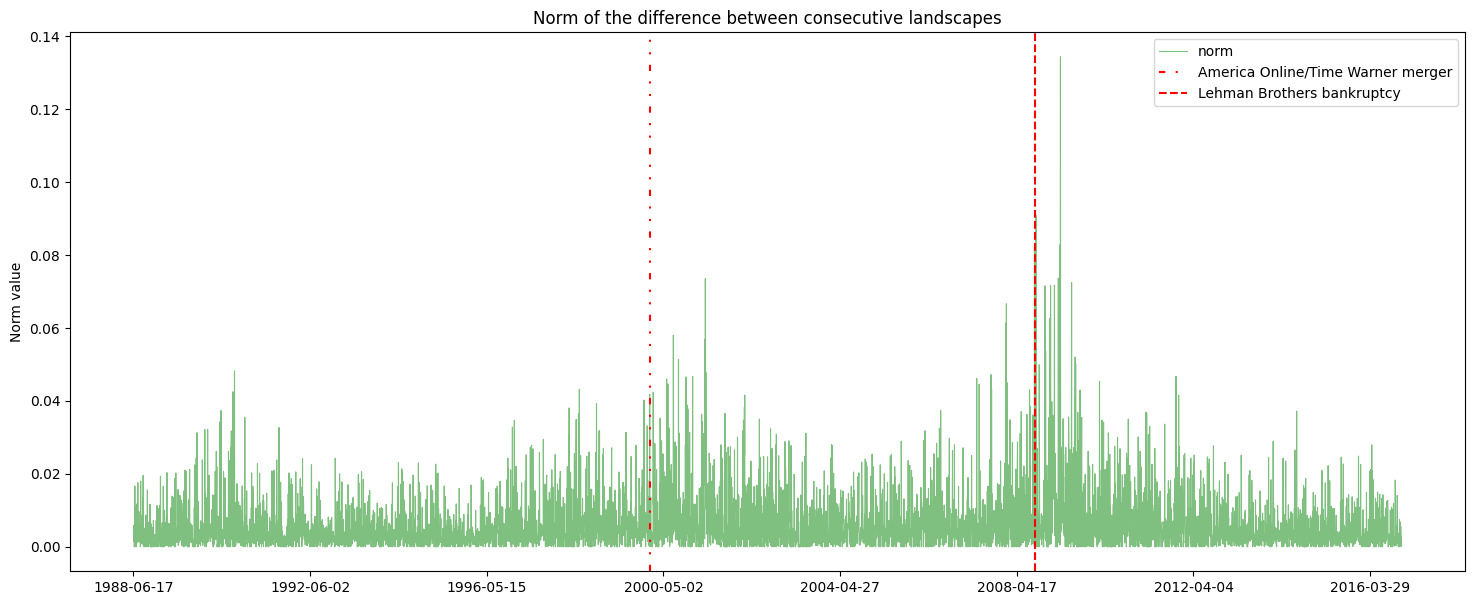

In [ ]:
norm_diff3 = compute_norm_difference_persistence_landscapes(data, l3)

<u>Bottleneck distance between diagrams:</u>


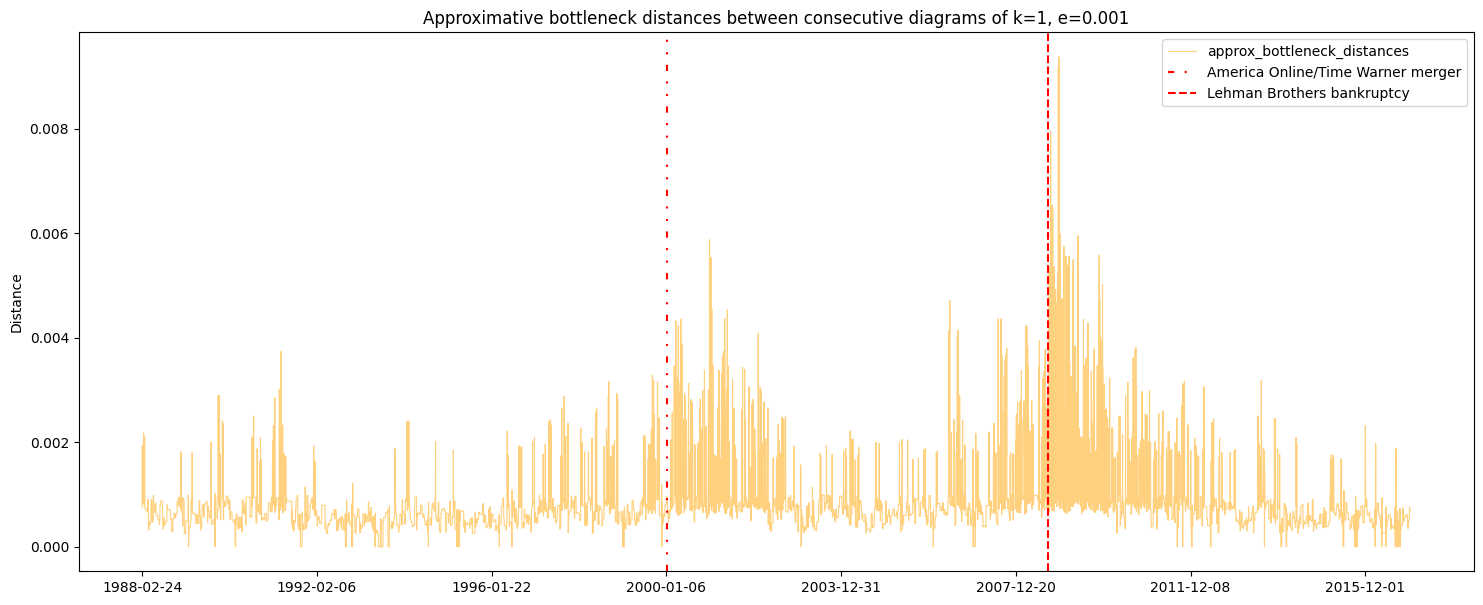

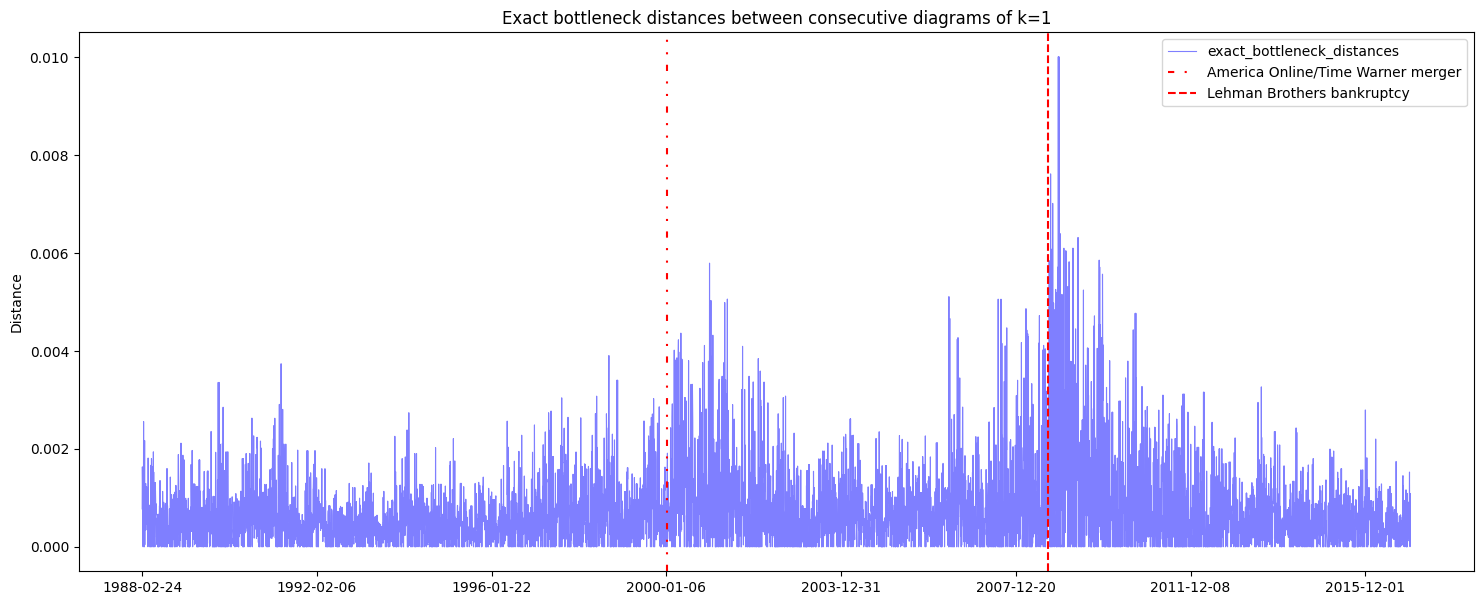

In [ ]:
bd1 = compute_bottleneck_distance_persistence_diagrams(data, d1)

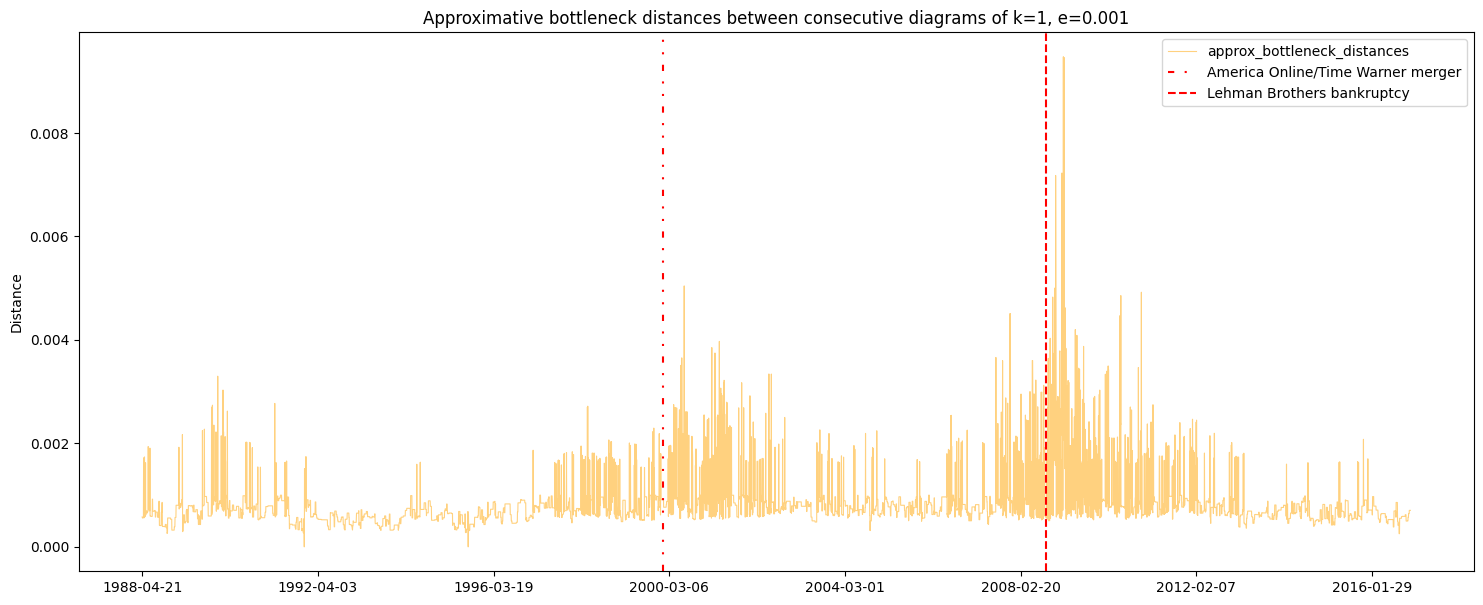

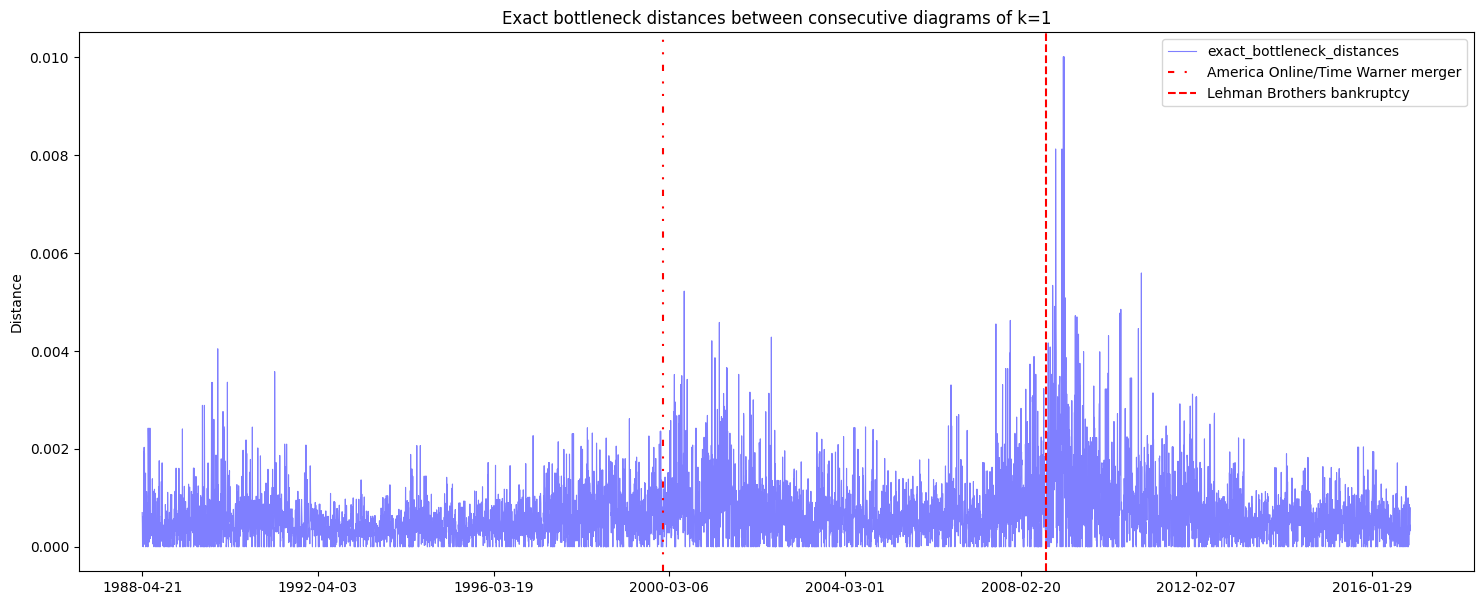

In [ ]:
bd2 = compute_bottleneck_distance_persistence_diagrams(data, d2)

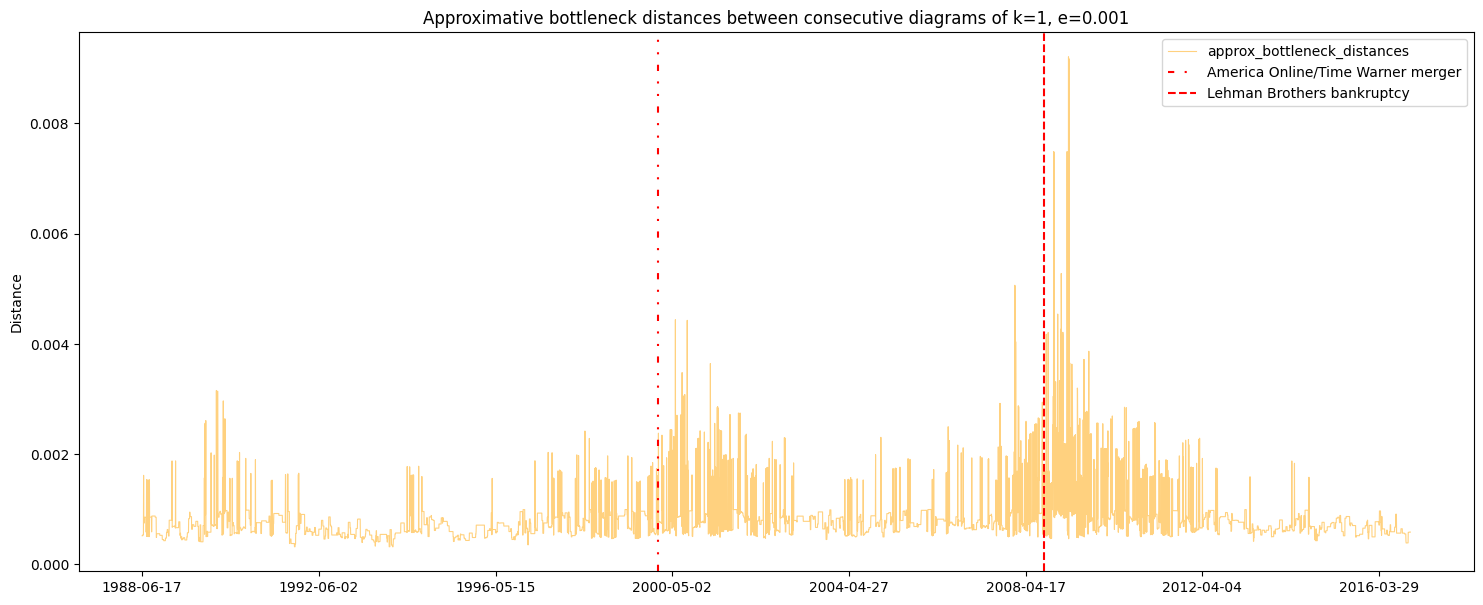

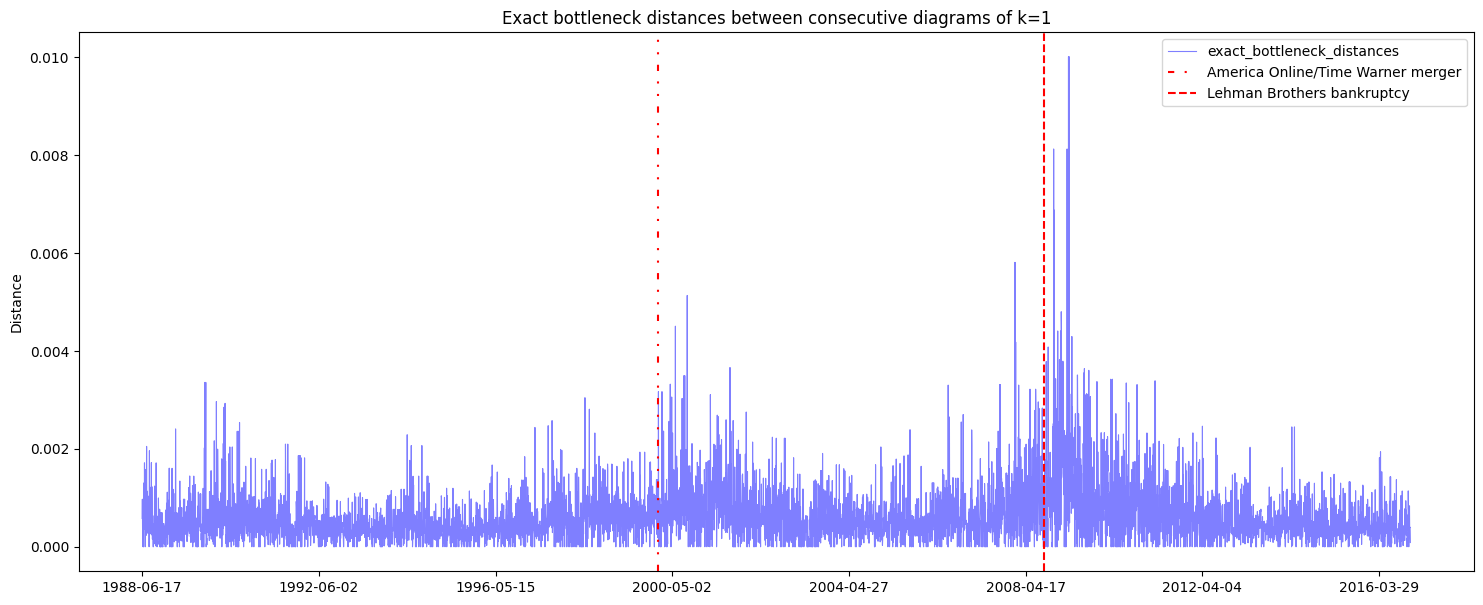

In [ ]:
bd3 = compute_bottleneck_distance_persistence_diagrams(data, d3)